In [1]:
import numpy as np
from scipy.integrate import ode
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib import gridspec
rc('animation', html='html5')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json

In [2]:
import sys
sys.path.append('/home/hudson/Projects/SIOC216B') #change this
from lib.params import *
from lib.moving_average import *
from lib.utils import *

In [6]:
class Vibes(object):
    def __init__(self, N=2, 
                 a=None, b=None, alpha=None, beta=None,
                 k=.25, eta=1,
                 Q=None, x0=None, v0=None, dt=.1, tau=20, gain=1,
                 rng = np.random.RandomState()):
        
        self.rng = rng
        
        #parameters
        self.N = N
        self.a = a if a is not None else genA(N, rng=rng)
        self.b = b if b is not None else genB(N, rng=rng)
        self.alpha = alpha if alpha is not None else genAlpha(N, rng=rng)
        self.beta = beta if beta is not None else genBeta(N, rng=rng)
        
        #spring
        self.k = k if k is not None else .25
        self.eta = eta if eta is not None else 1
        self.c = eta * 2 * np.sqrt(k)
        
        #connectivity
        self.Q = Q if Q is not None else np.ones((N,N)) 
        
        #initial conditions
        self.x0 = x0 if x0 is not None else rng.randn(N)
        self.v0 = v0 if v0 is not None else rng.randn(N)
        
        #Time constants and gain
        self.dt = dt
        self.tau = tau
        self.gain = gain
        
    def model(self, t, y, forces):
        #scipy solver takes input as a single vector.
        # We want to handle as two vectors so we split y in half
        x = y[:self.N]
        v = y[self.N:]

        #Passed forces
        I = forces['I'] 
        F = forces['F']
        noise = forces['noise']

        #Differential equation part
        dxdt = v
        dvdt = -self.k*x -self.c*v + np.tanh(self.gain*I) + F + noise

        #Since we split y in half we have to concatenate dxdt and dvdt 
        # into single vector
        f = np.vstack([dxdt, dvdt]).flatten()
        return(f)

    def run(self, time=100, F=None, Wf=None, noise = False):
        N = self.N
        #External forcing
        if F == None: 
            F = lambda x: 0
        if Wf == None:
            Wf = np.zeros(N)
            Wf[0] = 1
        
        y0 = np.vstack([self.x0, self.v0]).flatten()
        # Set up ode solver
        solver = ode(self.model)
        solver.set_initial_value(y0)
        #solver.set_integrator('vode', method='bdf', order=15)

        #Loop through ode solver and get values as you go
        t = [0]
        y = [y0]

        # For updating forces
        forces = {}

        self.WIJ = []
        self.trip = []    
        self.means = []
        self.variances = []
        self.covs = []
        self.Is = []
        
        #solver.successful ensures ode does not blow up
        # solver.t < t1 sets maximmum simulation length
        while solver.successful() and solver.t < time:  
            #Book-keeping
            x = y[-1][:N]

            #THESE VARIANCES, ETC SHOULD BE BASED ON f(x), NOT x?
            if t[-1] == 0:
                mean_x = np.zeros(N)
                var_x = (x - mean_x)**2
                cov_xx = np.outer((x - mean_x), (x - mean_x))
                fx = np.zeros((N,N))
                W = np.zeros((N,N))
                cij = np.zeros((N,N))
                c_star = np.zeros((N,N))
            else:
                mean_x = avgnext(mean_x, x, self.tau)
                var_x = varnext(var_x, mean_x, x, self.tau)
                for i in range(N):
                    for j in range(N):
                        cov_xx[i,j] = covnext(cov_xx[i,j], 
                                              mean_x[i], x[i],
                                              mean_x[j], x[j], self.tau)

            self.means.append(np.copy(mean_x))
            self.variances.append(np.copy(var_x))
            self.covs.append(np.copy(cov_xx))

            for i in range(N):
                for j in range(N):
                    cij[i,j] = self.alpha[i] * np.sqrt(var_x[j]) + self.beta[i] * np.abs(mean_x[j])
                    c_star[i,j] = cij[i,j] / 2

            ntrip = [0, 0]
            for i in range(N):
                for j in range(N):
                    if i != j and self.Q[i,j] != 0:
                        fx[i,j], tripped = f_ij(x[j], mean_x[j], var_x[j], 
                                       self.alpha[i], self.beta[i], cij[i,j], c_star[i,j])
                        ntrip = np.add(ntrip, tripped)
                    else:
                        fx[i,j] = 0
            self.trip.append(ntrip)

            for i in range(N):
                for j in range(N):
                    if i != j and self.Q[i,j] != 0:
                        W[i,j] = self.Q[i,j] * w_ij(var_x[j], cov_xx[i,j],
                                               self.a[i], self.b[i])
                    else:
                        W[i,j] = 0
            self.WIJ.append(np.copy(W))

            forces['I'] = np.multiply(W, fx).sum(axis=1)
            self.Is.append(forces['I'])
            forces['F'] = np.multiply(Wf, F(t[-1]))
            forces['noise'] = 0 if not noise else .5*self.rng.randn(N)

            solver.set_f_params(forces)

            #t.t + dt is current time + dt
            solver.integrate(solver.t+self.dt)
            #record output t and y
            t.append(solver.t)
            y.append(solver.y)
            
            
        self.t = t
        self.y = y
        x = np.array(y)[:,:N]
        v = np.array(y)[:,N:]
        self.x = x
        self.v = v
        
        
        #Plot
        fig = plt.figure(figsize=(15,20))
        gs = gridspec.GridSpec(7, 2)
        
        ax1 = fig.add_subplot(gs[0,:])
        ax1.plot(t, [F(ti) for ti in t])
        ax1.set_title('External Forcing')
        ax1.set_ylabel('F')
        ax1.set_xlabel('t')

        ax2 = fig.add_subplot(gs[1,:])
        ax2.plot(t, self.x)
        ax2.set_title('Perceived Happiness')
        ax2.set_ylabel('x')
        ax2.set_xlabel('t')

        ax3 = fig.add_subplot(gs[2,:])
        ax3.plot(t, self.v)
        ax3.set_title('Actual Happiness')
        ax3.set_ylabel('v')
        ax3.set_xlabel('t')
        
        #Is
        ax4 = fig.add_subplot(gs[3,0])
        for i in range(self.N):
            ax4.plot(self.t[1:], np.tanh(self.gain*np.array(self.Is)[:,i]))
        ax4.set_title('tanh(%s*I(t))' %self.gain)
        ax4.set_xlabel('t')
        
        #Trips
        ax5 = fig.add_subplot(gs[3,1])
        ax5.plot(self.t[1:], np.array(self.trip)[:,0]/(self.N**2 - self.N), label='c_ij')
        ax5.plot(self.t[1:], np.array(self.trip)[:,1]/(self.N**2 - self.N), label='c_ij star')
        ax5.set_title('trips')
        ax5.set_xlabel('t')
        ax5.set_ylim([-.1,1.1])
        ax5.legend()
        
        #Wij
        ax6 = fig.add_subplot(gs[4,0])
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    ax6.plot(self.t[1:], np.array(self.WIJ)[:, i, j], label = 'w_%s%s' %(i, j))
        if self.N <= 3: ax6.legend()
        ax6.set_xlabel('t')
        ax6.set_title('W_ij')
        
        #Means
        ax7 = fig.add_subplot(gs[4,1])
        for i in range(self.N):
            ax7.plot(self.t[1:],np.array(self.means)[:,i])
        ax7.set_xlabel('t')
        ax7.set_title('means')
        
        #Variances
        ax8 = fig.add_subplot(gs[5,0])
        for i in range(self.N):
            ax8.plot(self.t[1:],np.array(self.variances)[:,i])
        ax8.set_xlabel('t')
        ax8.set_title('variances')
        
        #Covs
        ax9 = fig.add_subplot(gs[5,1])
        for i in range(self.N):
            for j in range(self.N):
                if i != j and i<j:
                    ax9.plot(self.t[1:], np.array(self.covs)[:, i, j], label = 'cov_%s%s' %(i, j))
        if self.N <= 3: ax9.legend()
        ax9.set_xlabel('t')
        ax9.set_title('covariances')
        
        #Parameters
        ax10 = fig.add_subplot(gs[6,0])
        ax10.scatter(self.a,self.b)
        ax10.set_xlabel('a')
        ax10.set_ylabel('b')
        ax10.set_title('Parameters')
        
        #Initial conditions
        ax11 = fig.add_subplot(gs[6,1])
        ax11.scatter(self.x0,self.v0)
        ax11.set_xlabel('x0')
        ax11.set_ylabel('v0')
        ax11.set_title('Initial conditions')
        
        gs.update(wspace=.2, hspace=.6)
        
        self.fig = fig
        
        return(x,v,t)
    
    def save(self, imageName, comments = None):
        with open('../Investigation/' + 'parameters.txt', 'a') as outfile:
            infodict = {
                'N': self.N,
                'a': str(self.a),
                'b': str(self.b),
                'alpha': str(self.alpha),
                'beta': str(self.beta),
                'x0': str(self.x0),
                'v0': str(self.v0),
                'image': imageName,
                'comments': comments
            }
            json.dump(infodict, outfile, indent=2)
            outfile.write('\n')
        self.fig.savefig('../Investigation/' + imageName + '.png')

In [7]:
vibes = Vibes(N = 10, gain=1, rng = np.random.RandomState(1234))

def F(t):
    if t < 50 and t > 49:
        return(1)
    elif t < 15 and t > 14:
        return(1)
    elif t < 80 and t > 79:
        return(-1)
    else: return(0)

In [ ]:
x, v, t = vibes.run()

In [158]:
vibes.save('random')

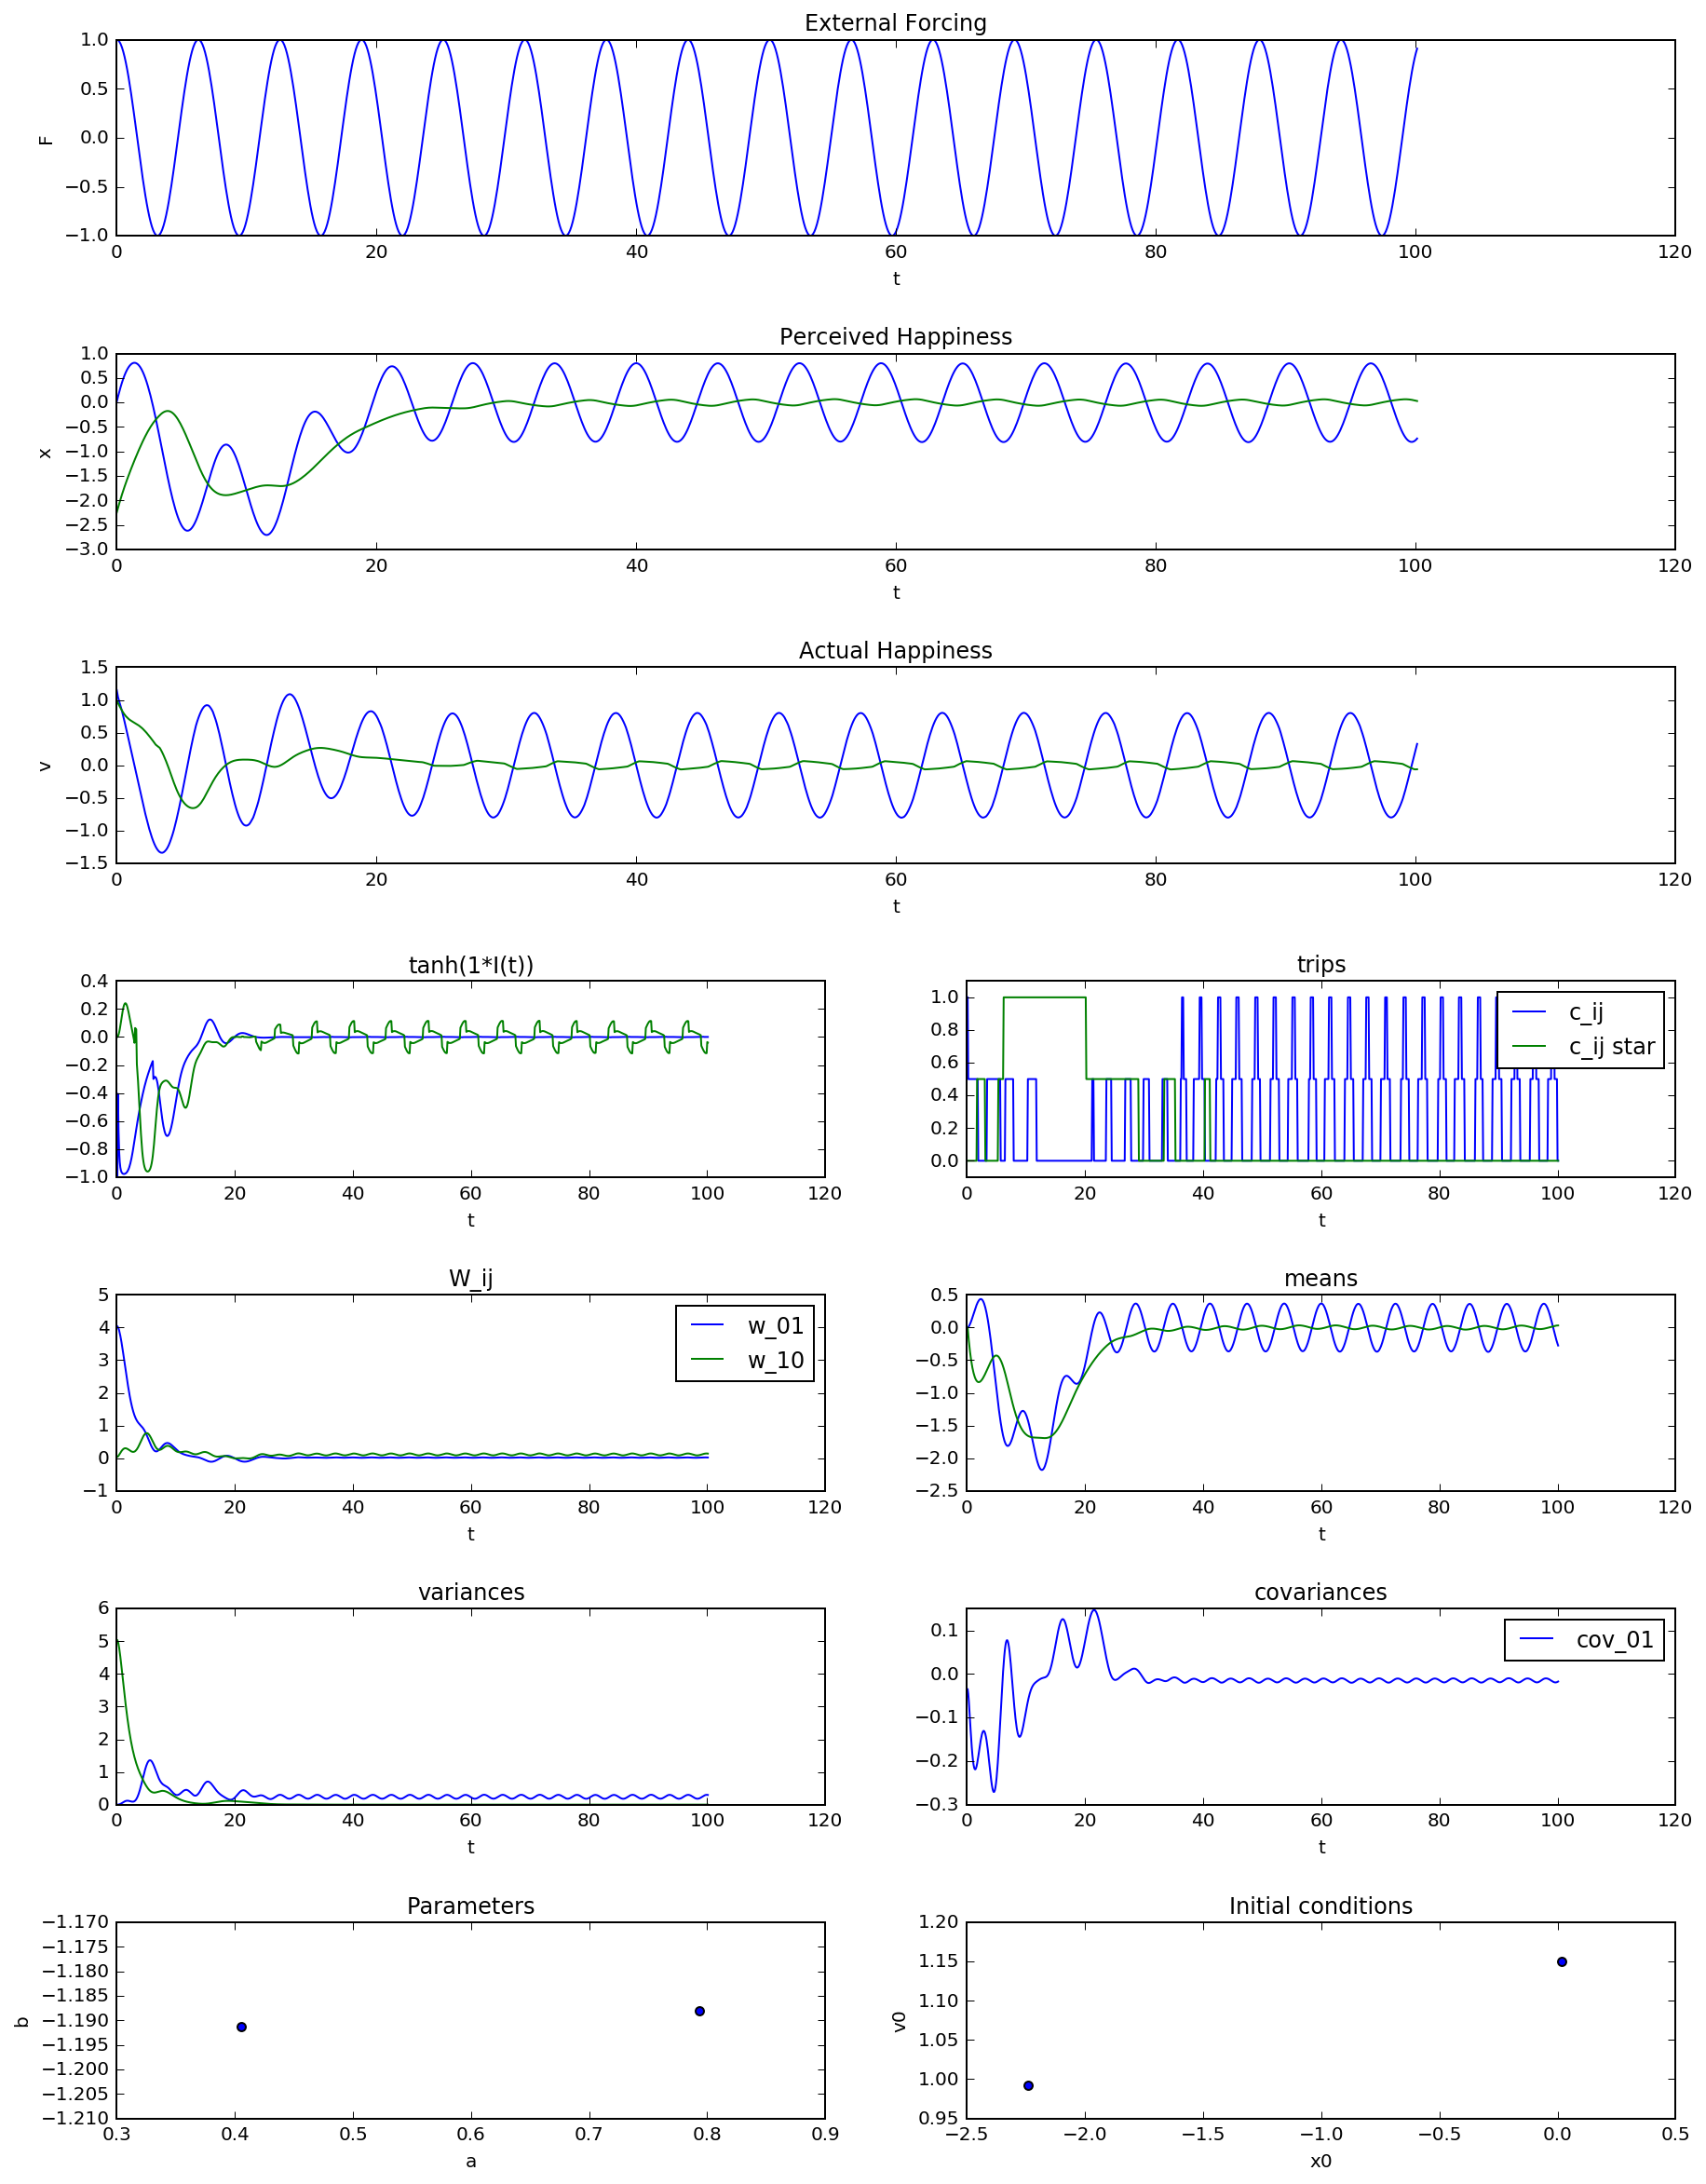

In [159]:
x, v, t = vibes.run(F=lambda x: np.cos(x))

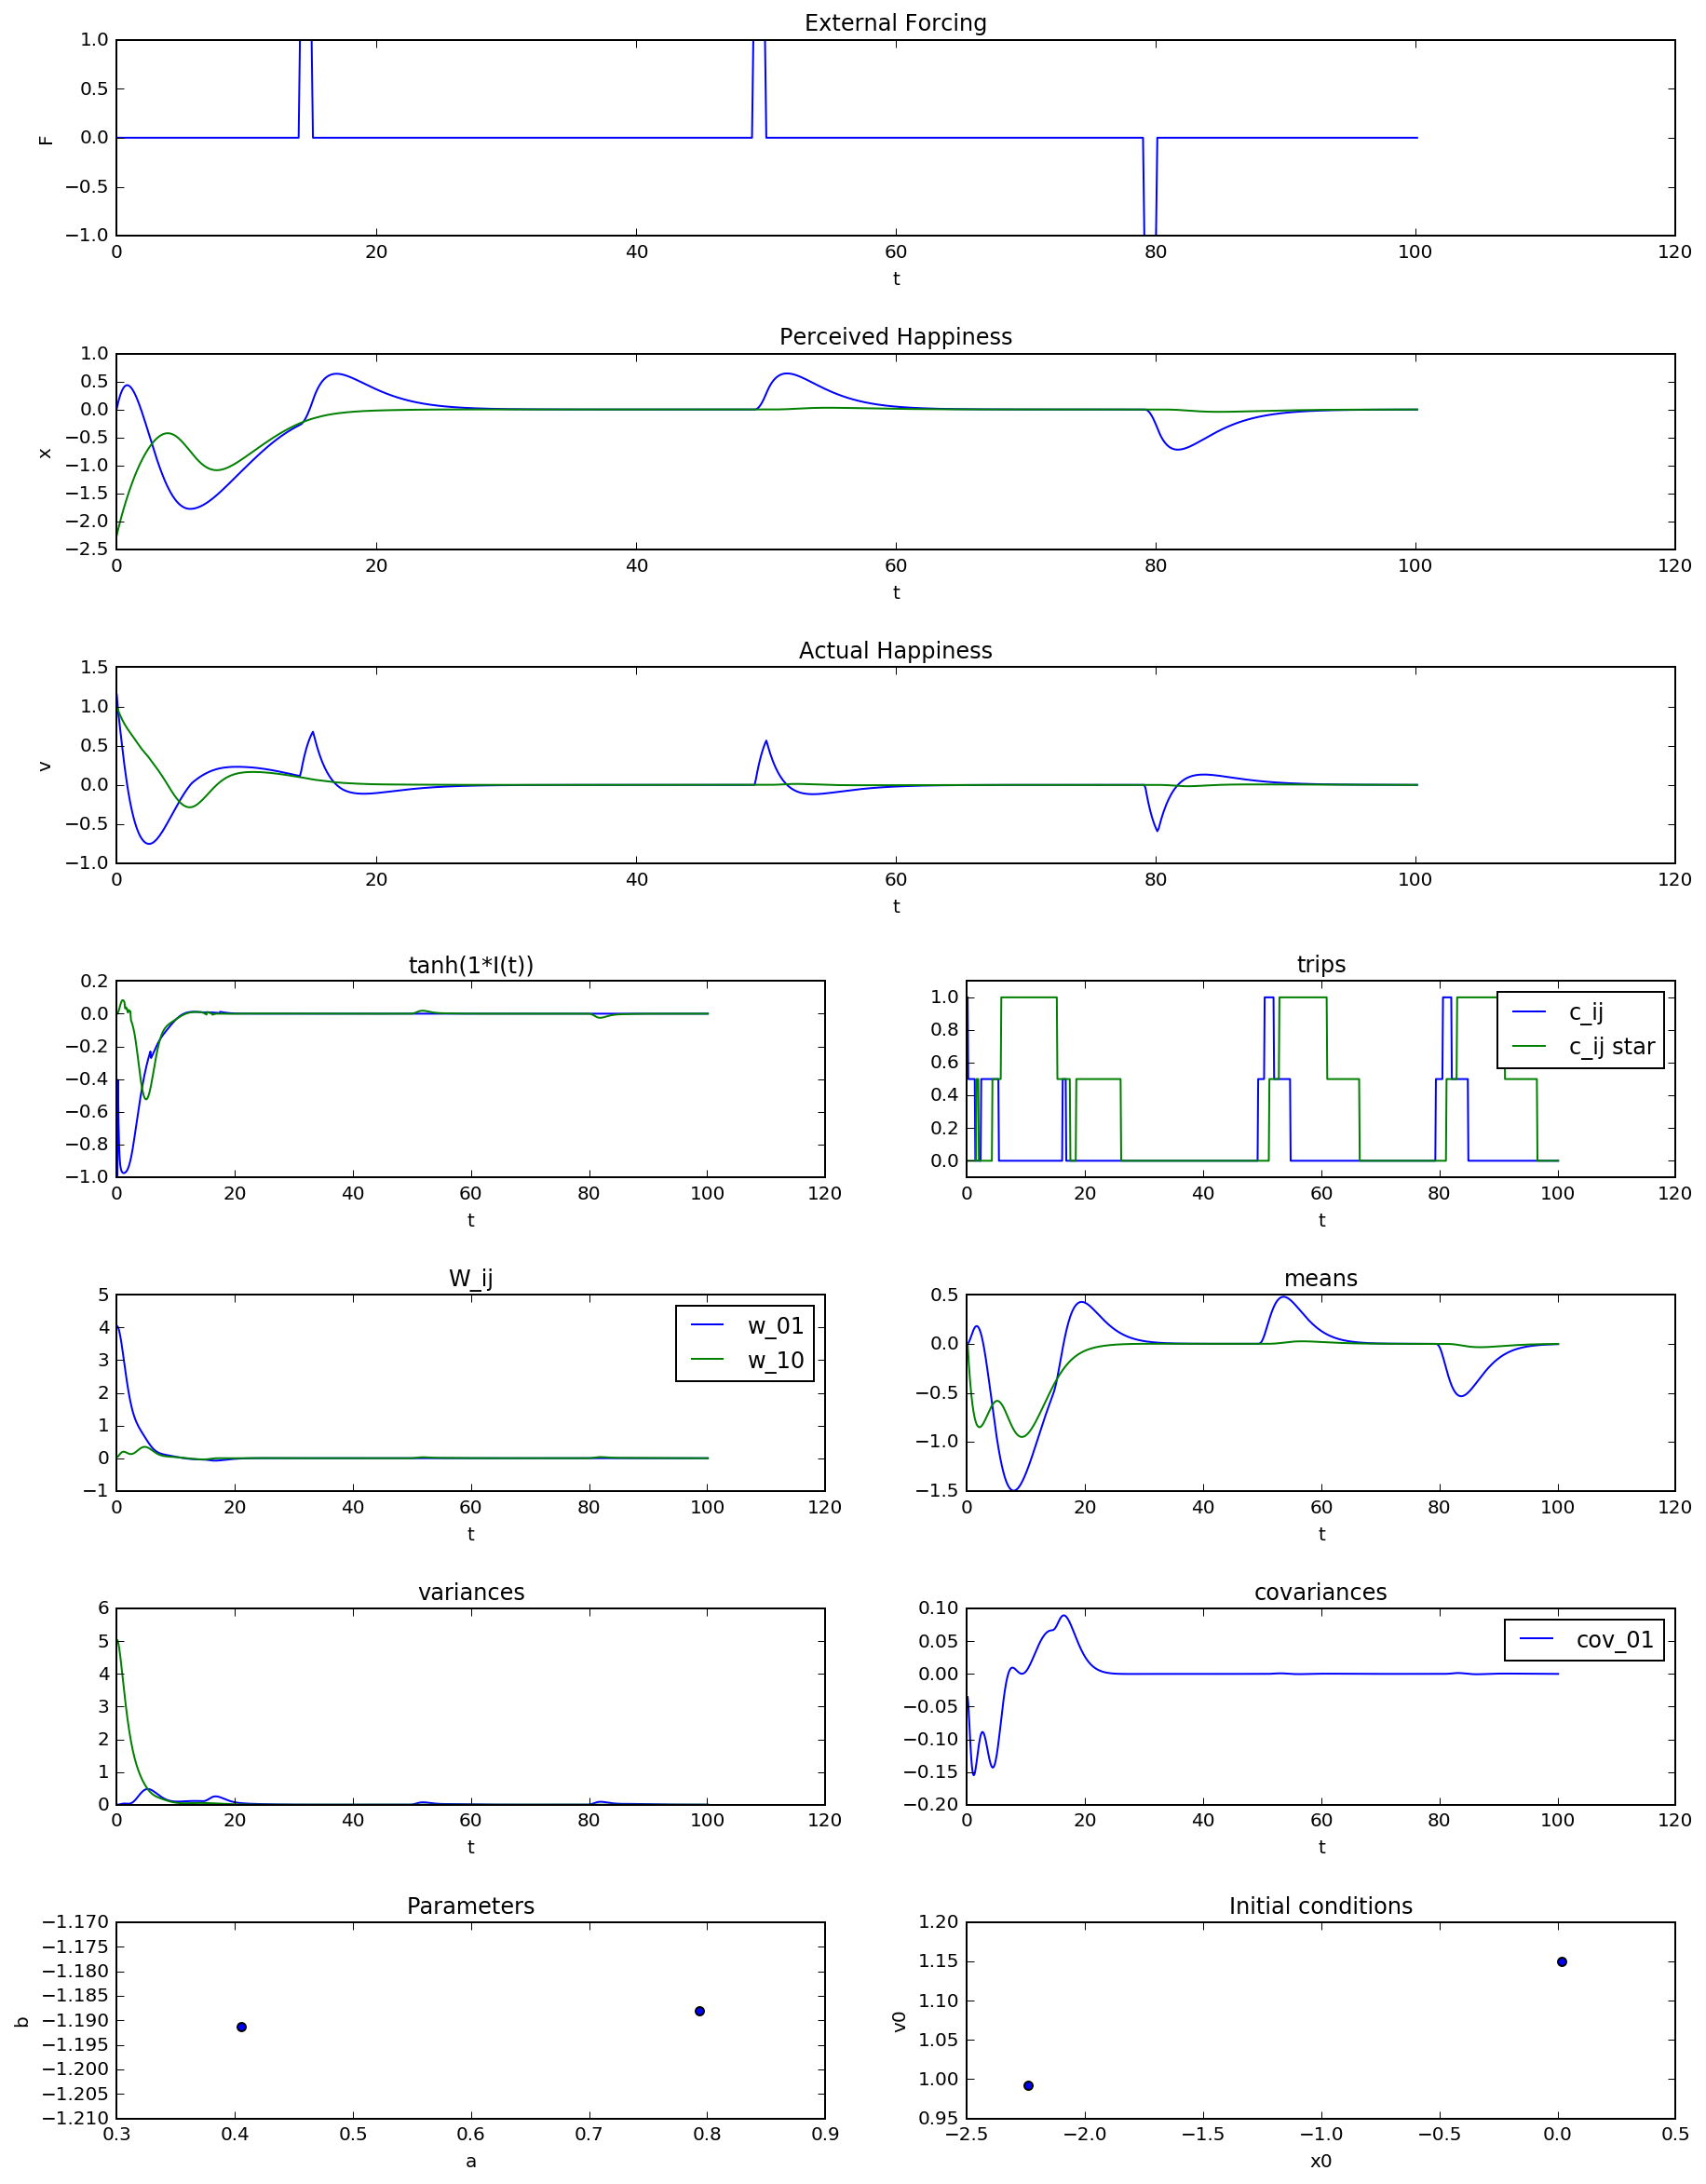

In [108]:
x, v, t = vibes.run(F=F)

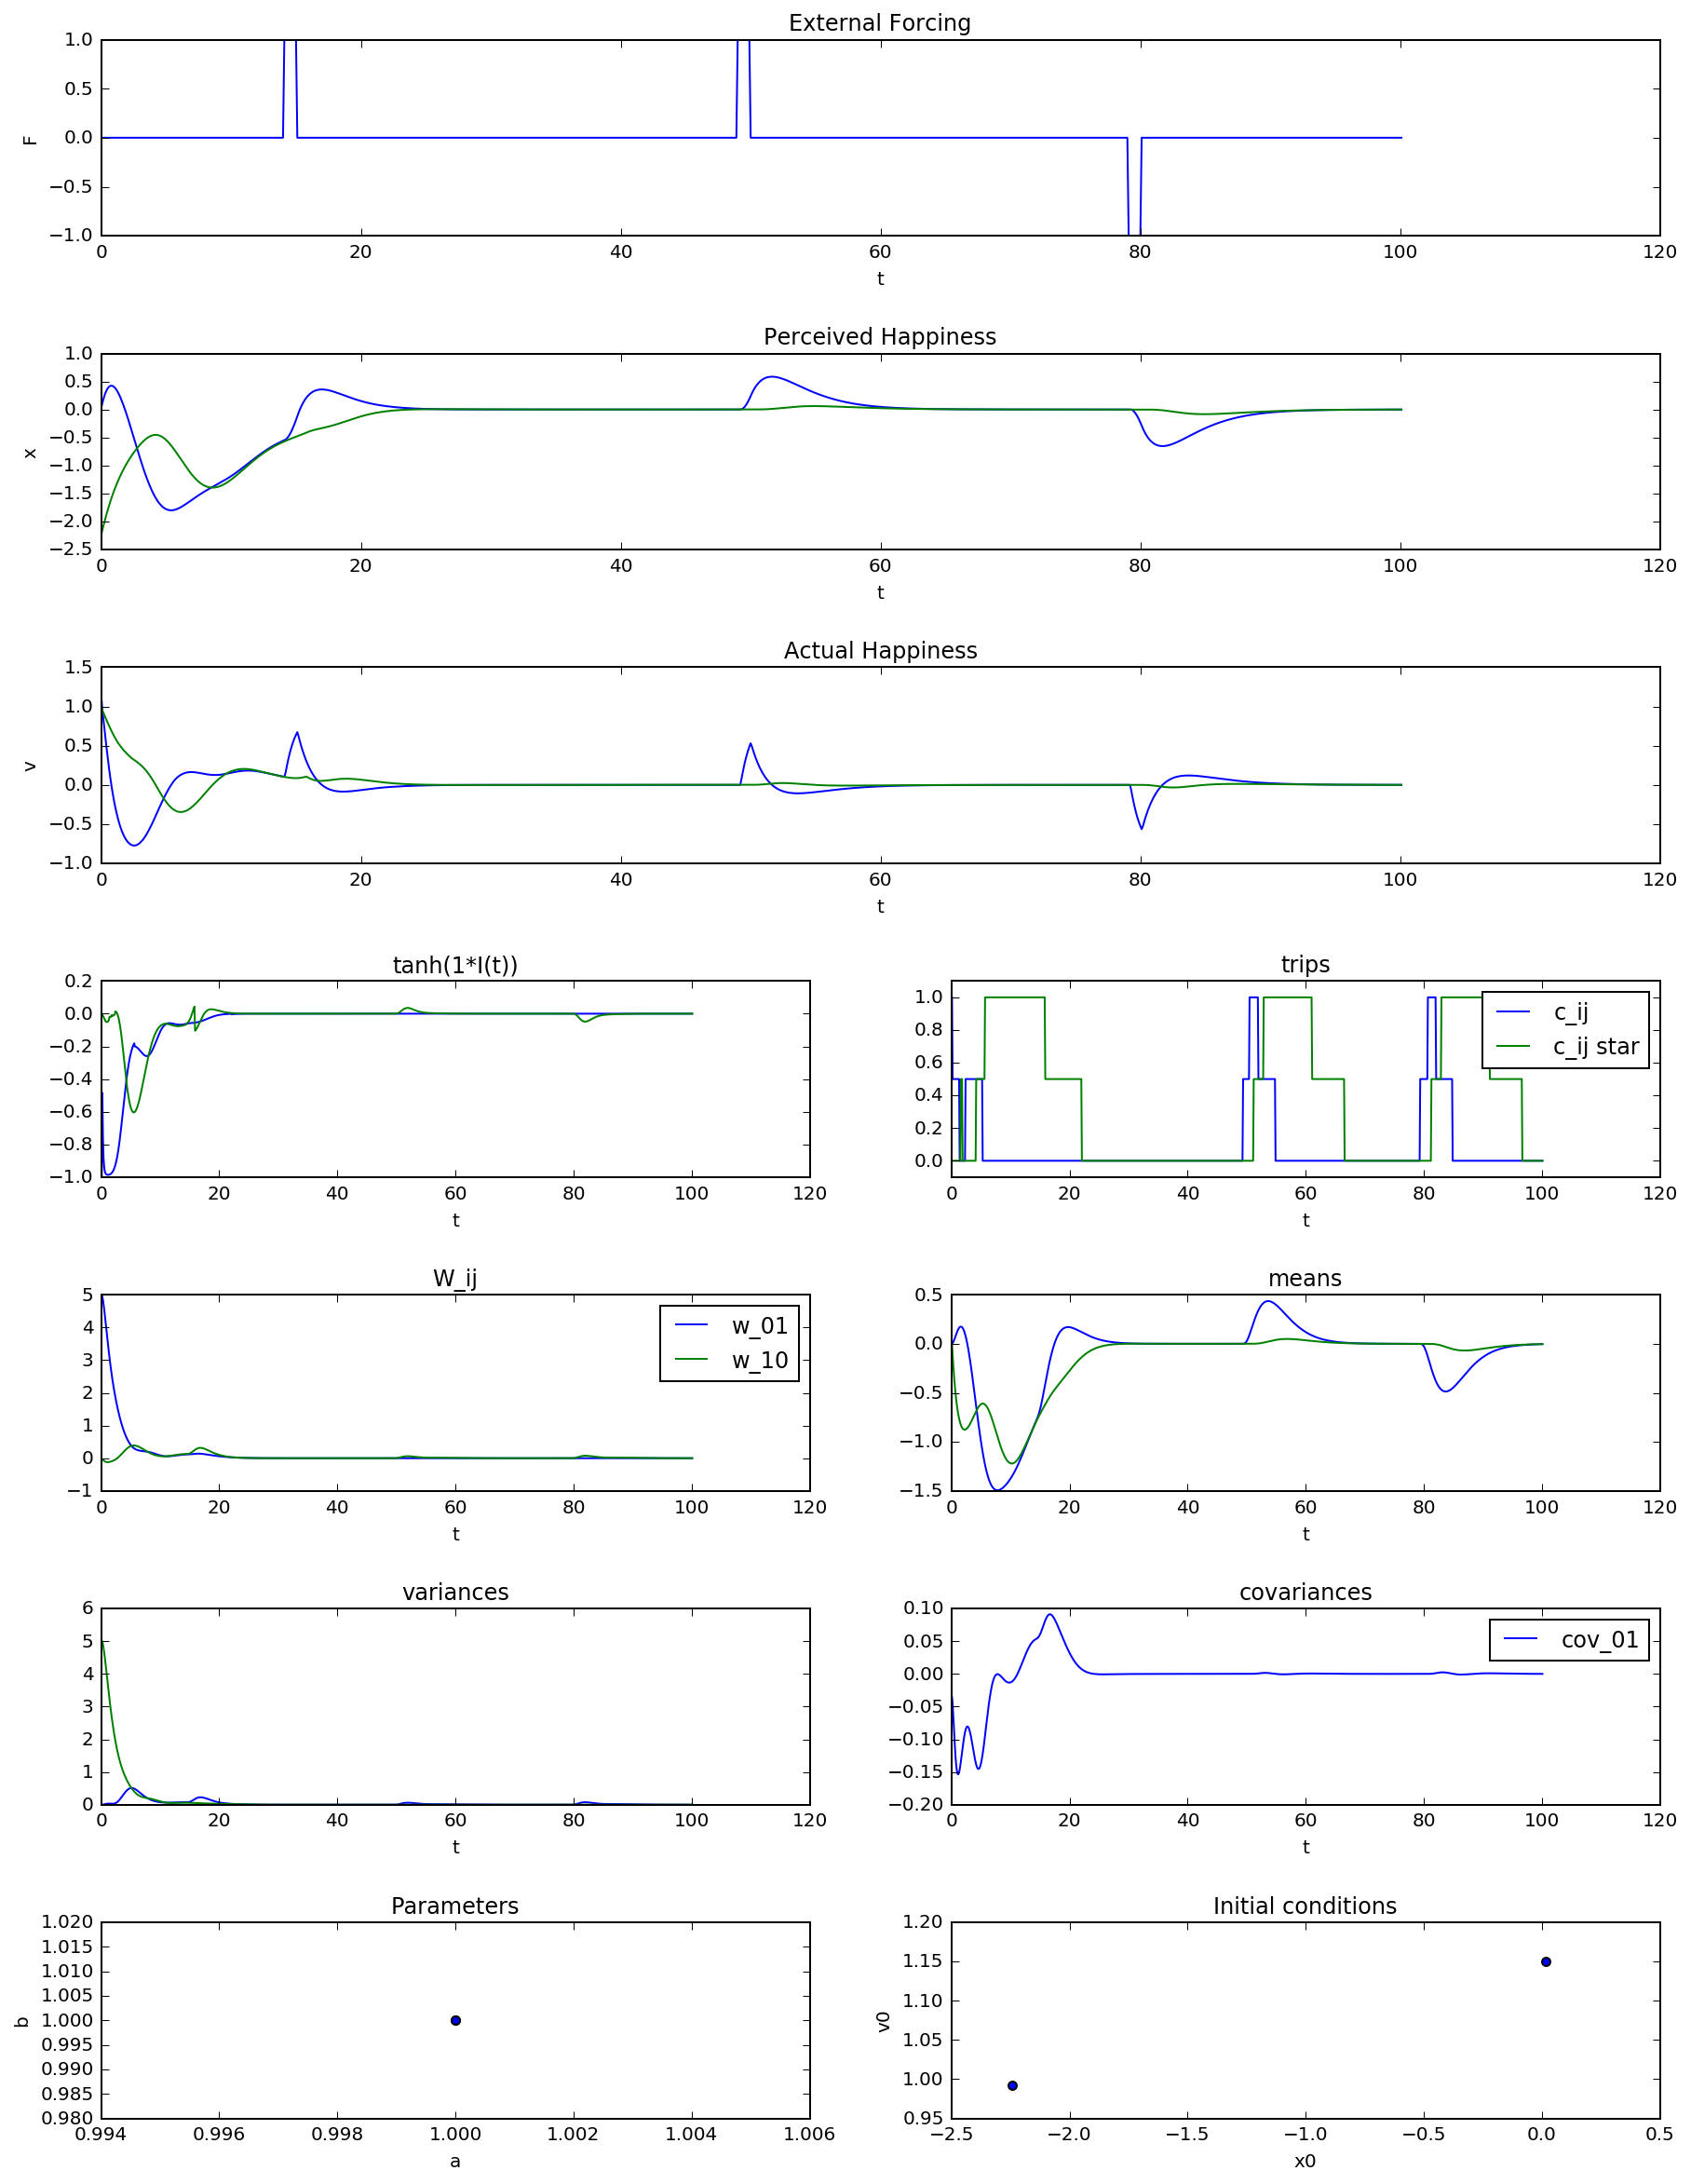

In [160]:
vibes.a = np.array([1,1])
vibes.b = np.array([1,1])
x, v, t = vibes.run(F=F)

In [161]:
vibes.save('allone')

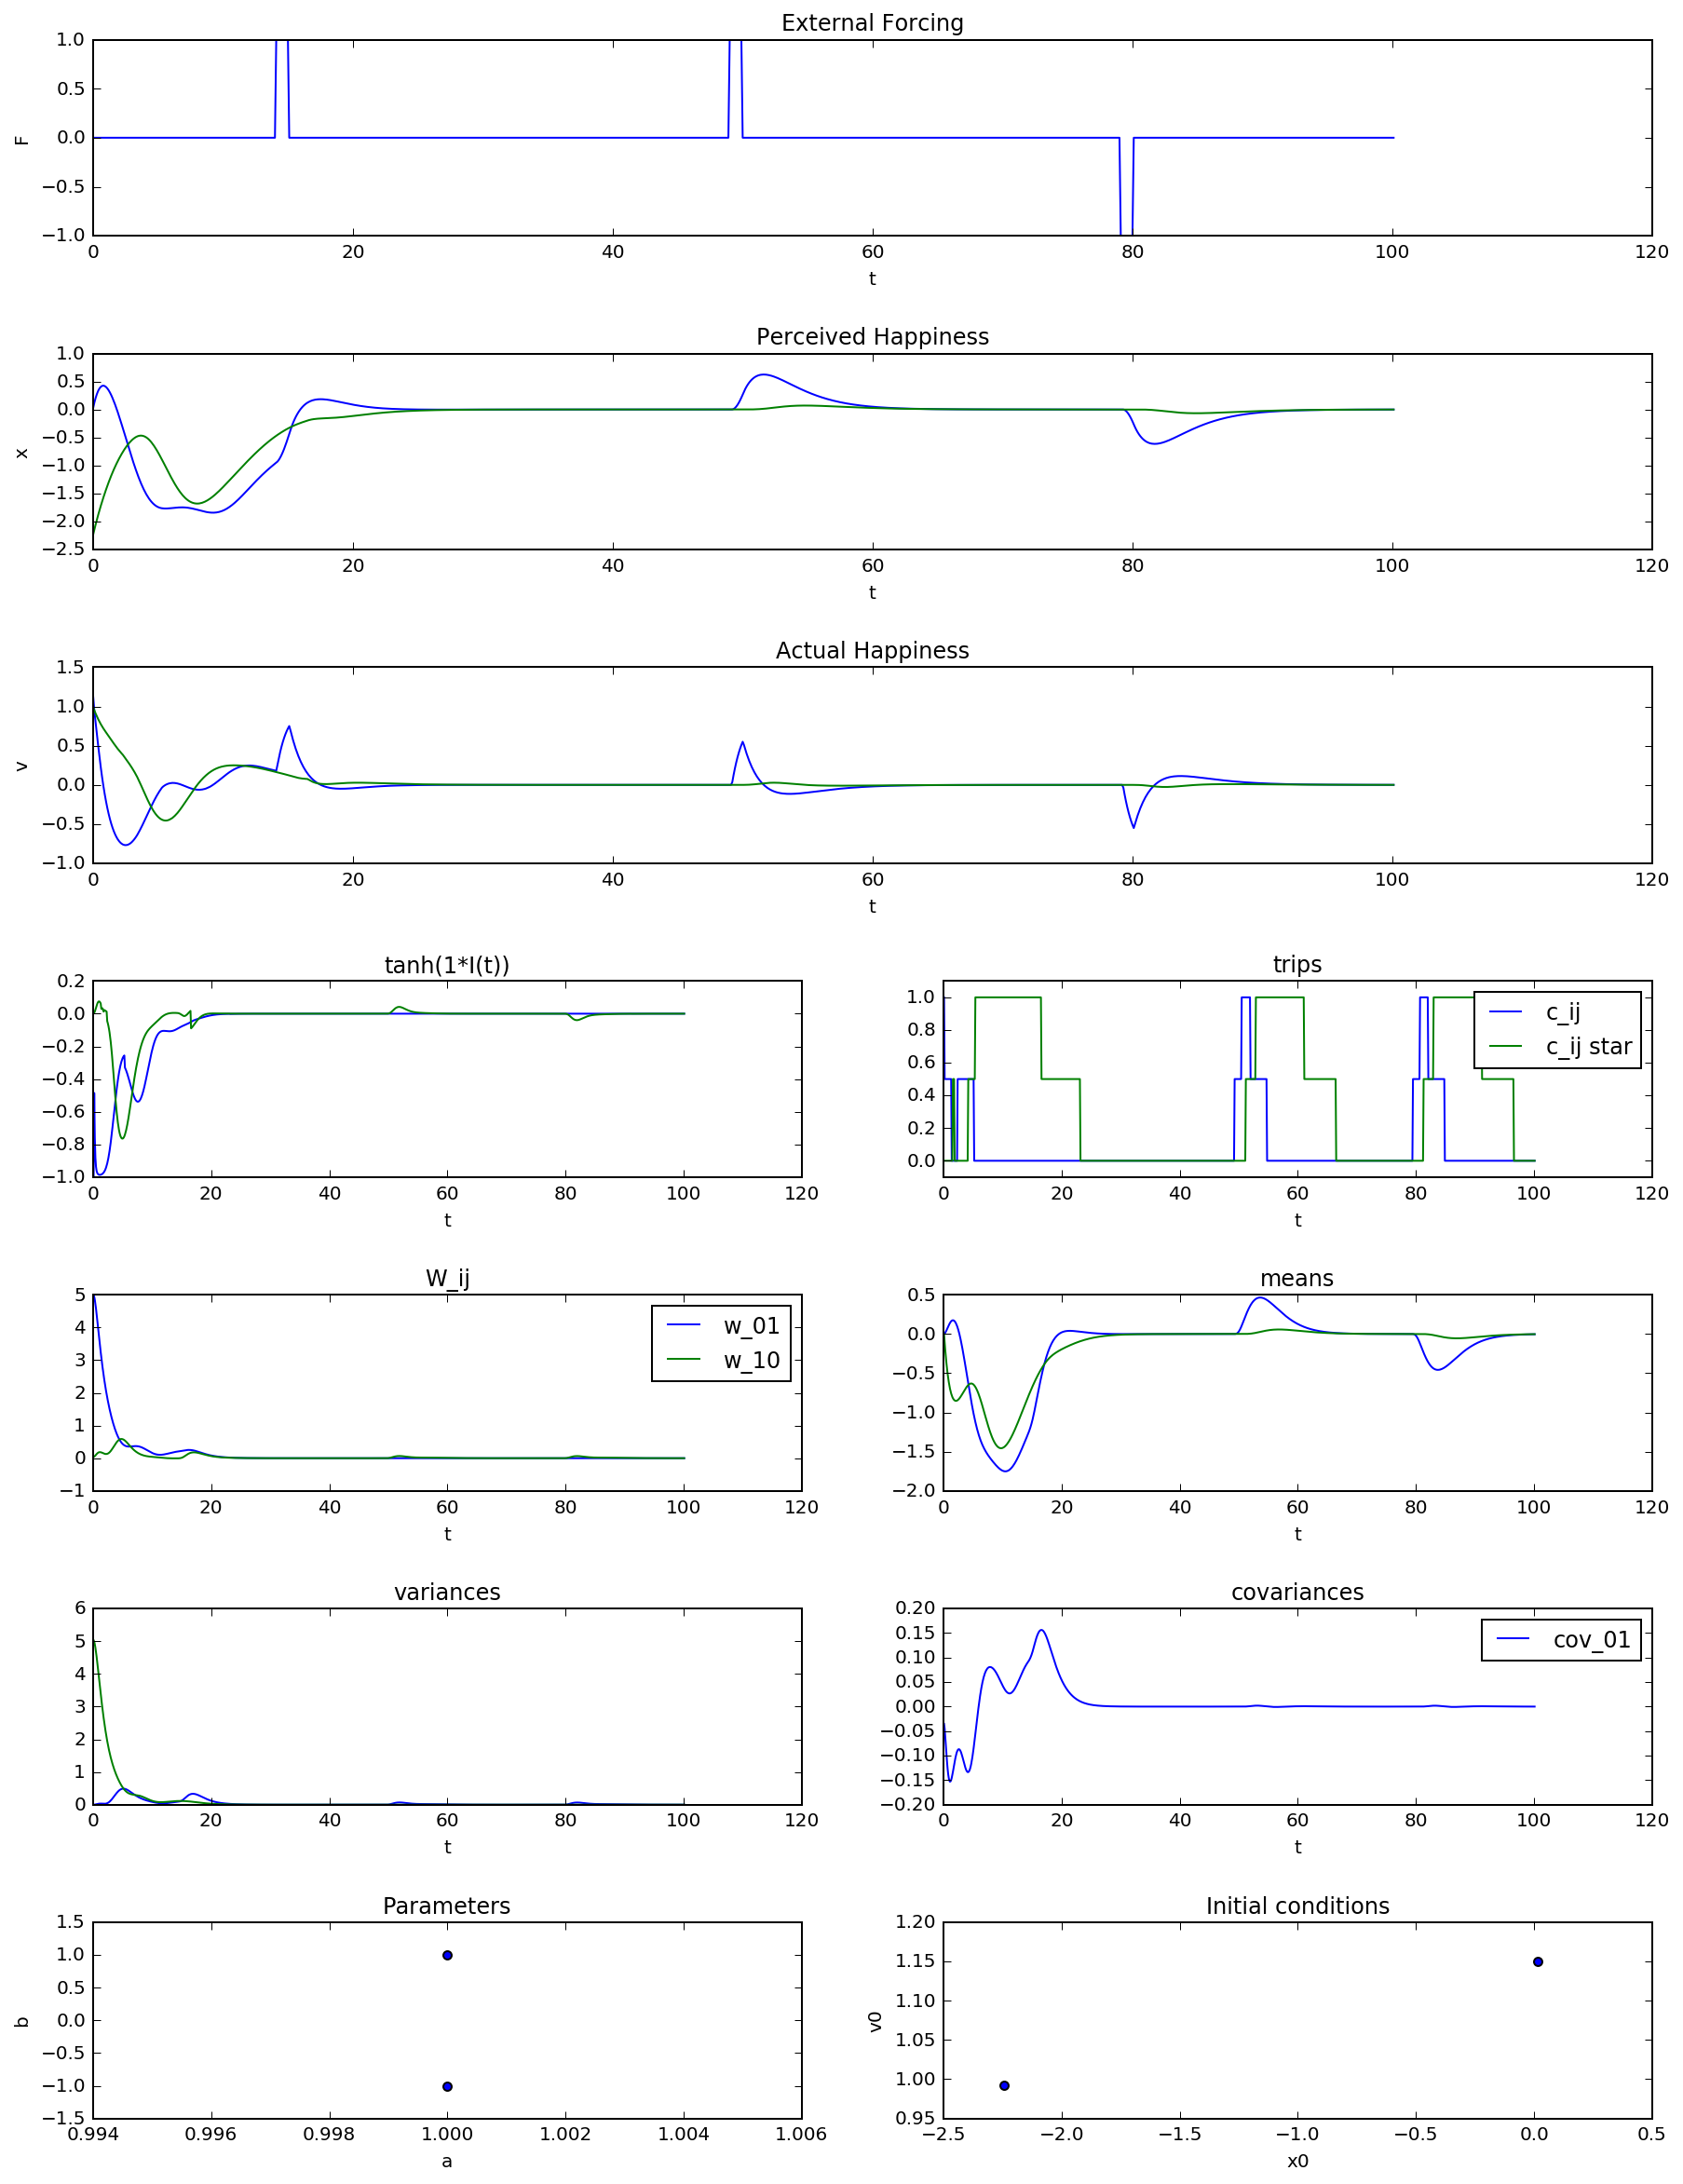

In [162]:
vibes.a = np.array([1,1])
vibes.b = np.array([1,-1])
x, v, t = vibes.run(F=F)

In [163]:
vibes.save('trial1/1bneg1', comments='mild following')

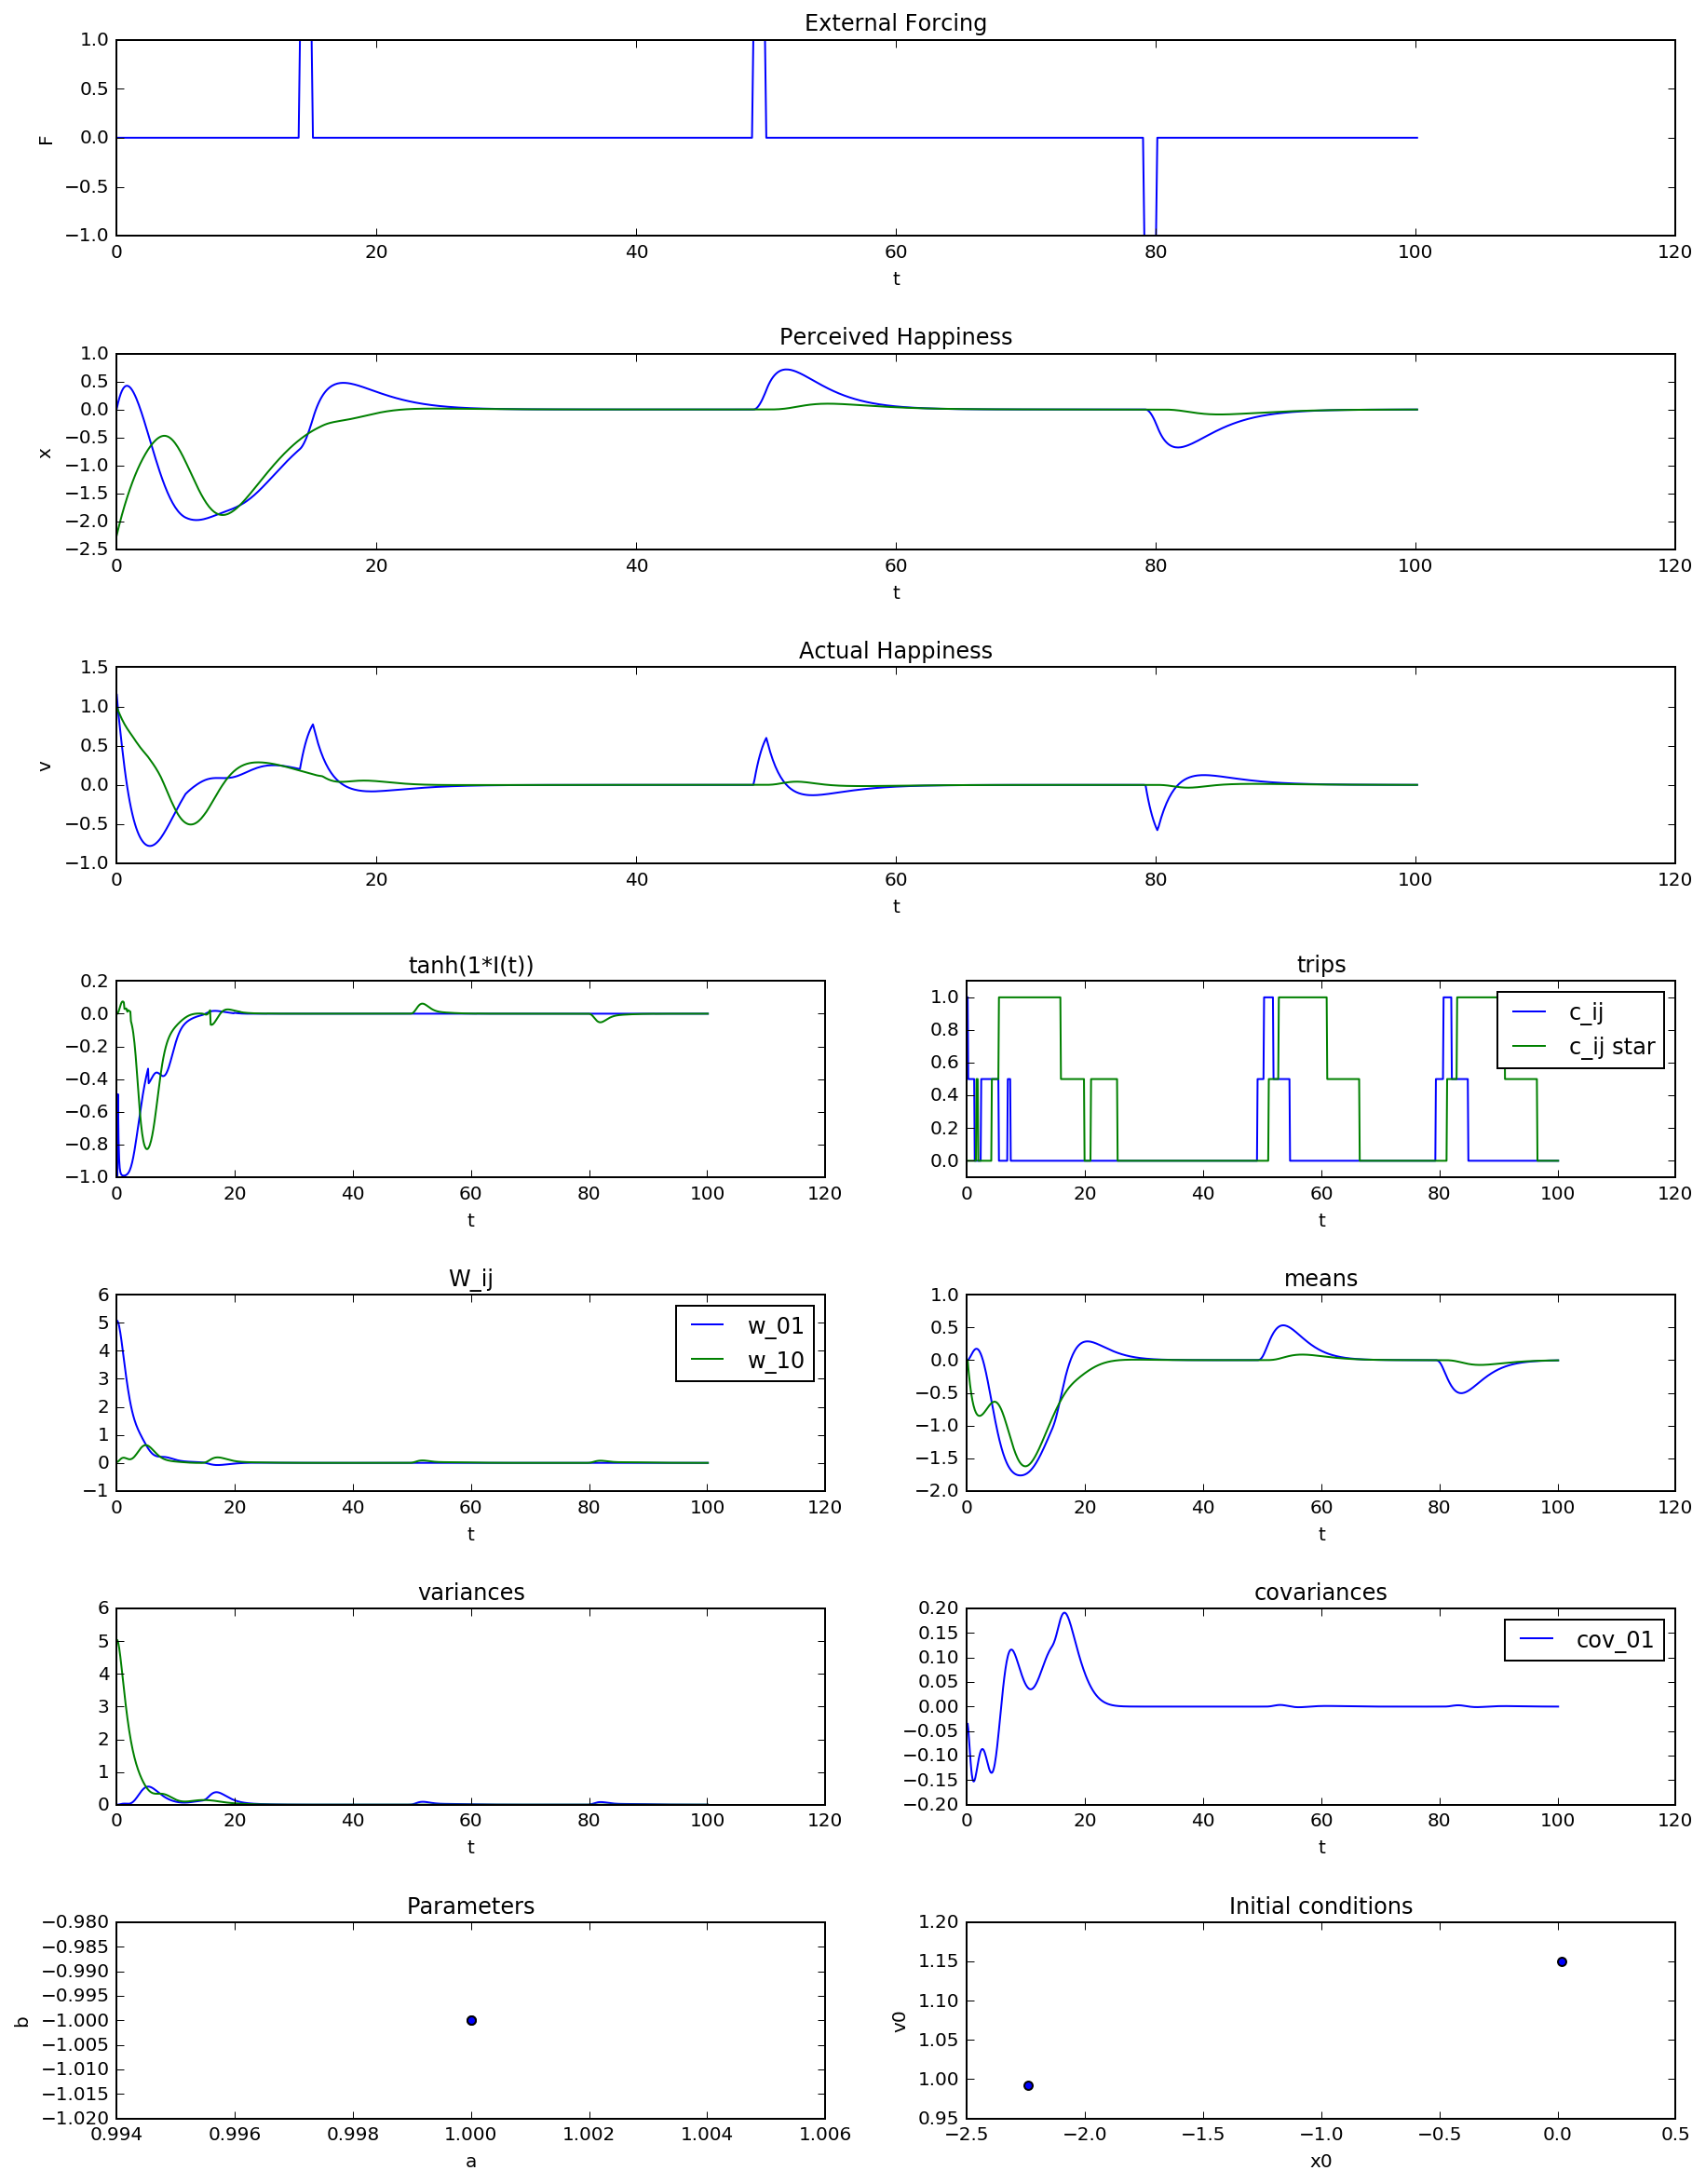

In [111]:
vibes.a = np.array([1,1])
vibes.b = np.array([-1,-1])
x, v, t = vibes.run(F=F)

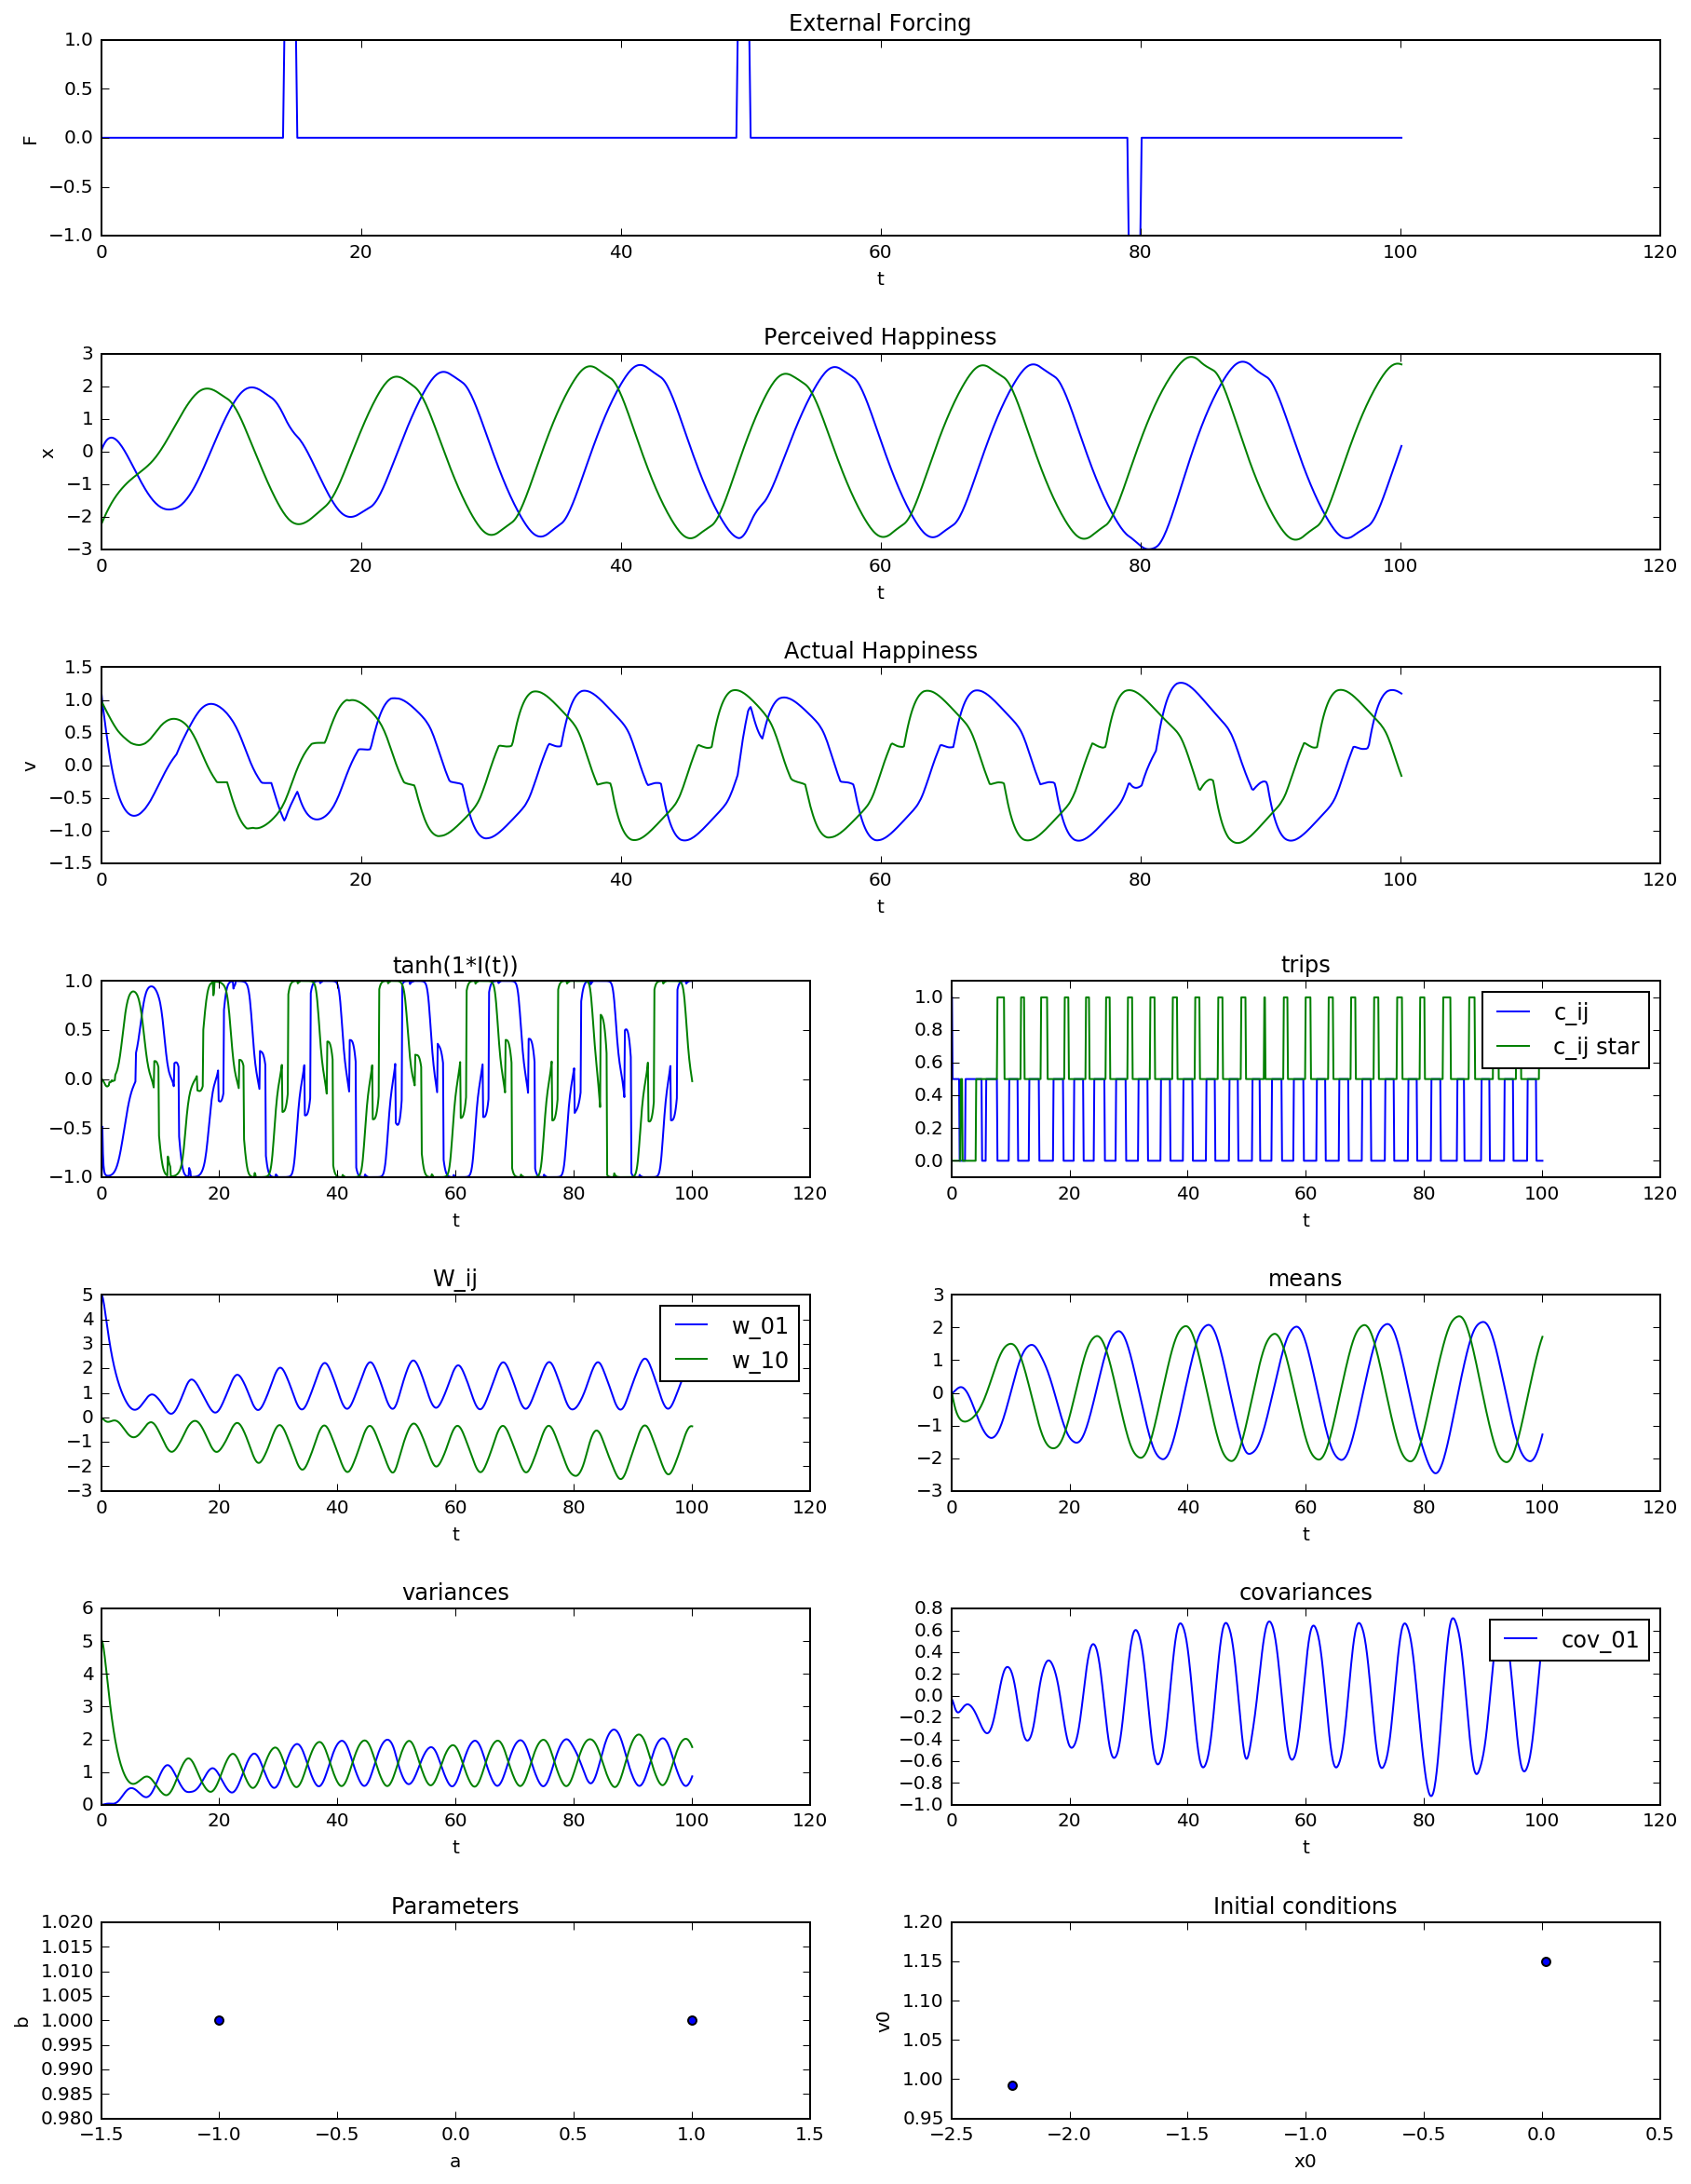

In [112]:
vibes.a = np.array([1,-1])
vibes.b = np.array([1,1])
x, v, t = vibes.run(F=F)

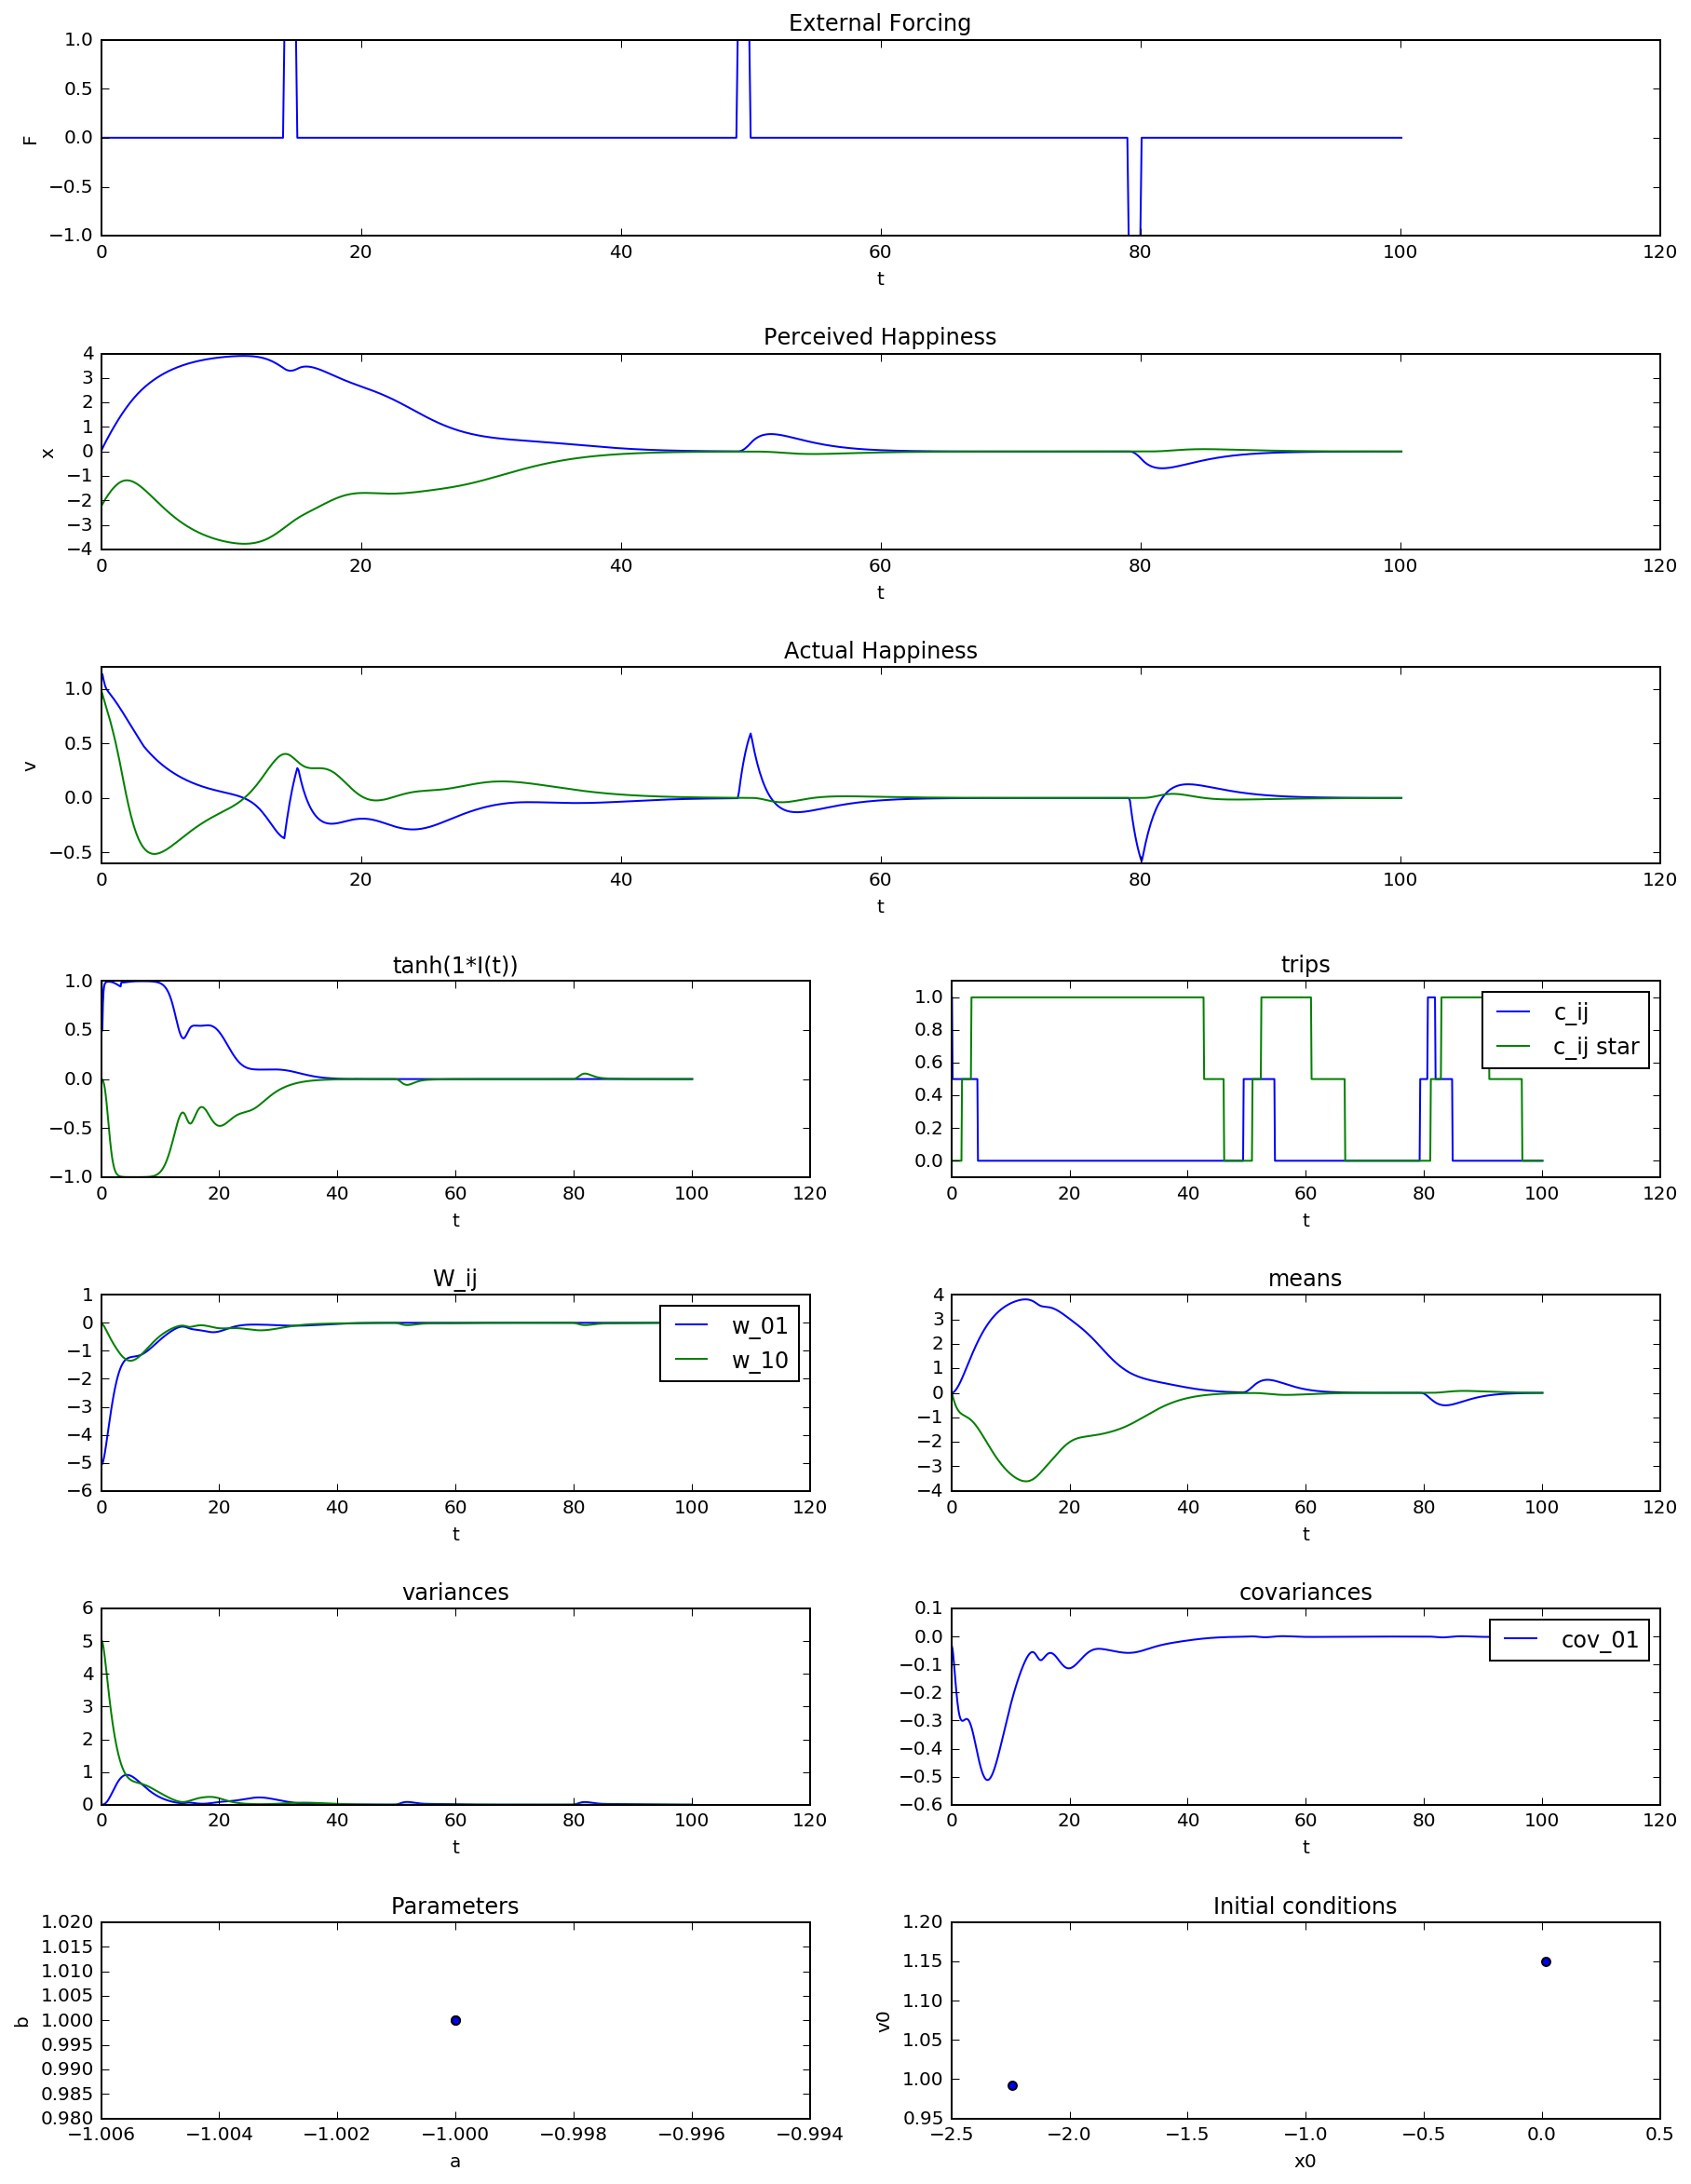

In [113]:
vibes.a = np.array([-1,-1])
vibes.b = np.array([1,1])
x, v, t = vibes.run(F=F)

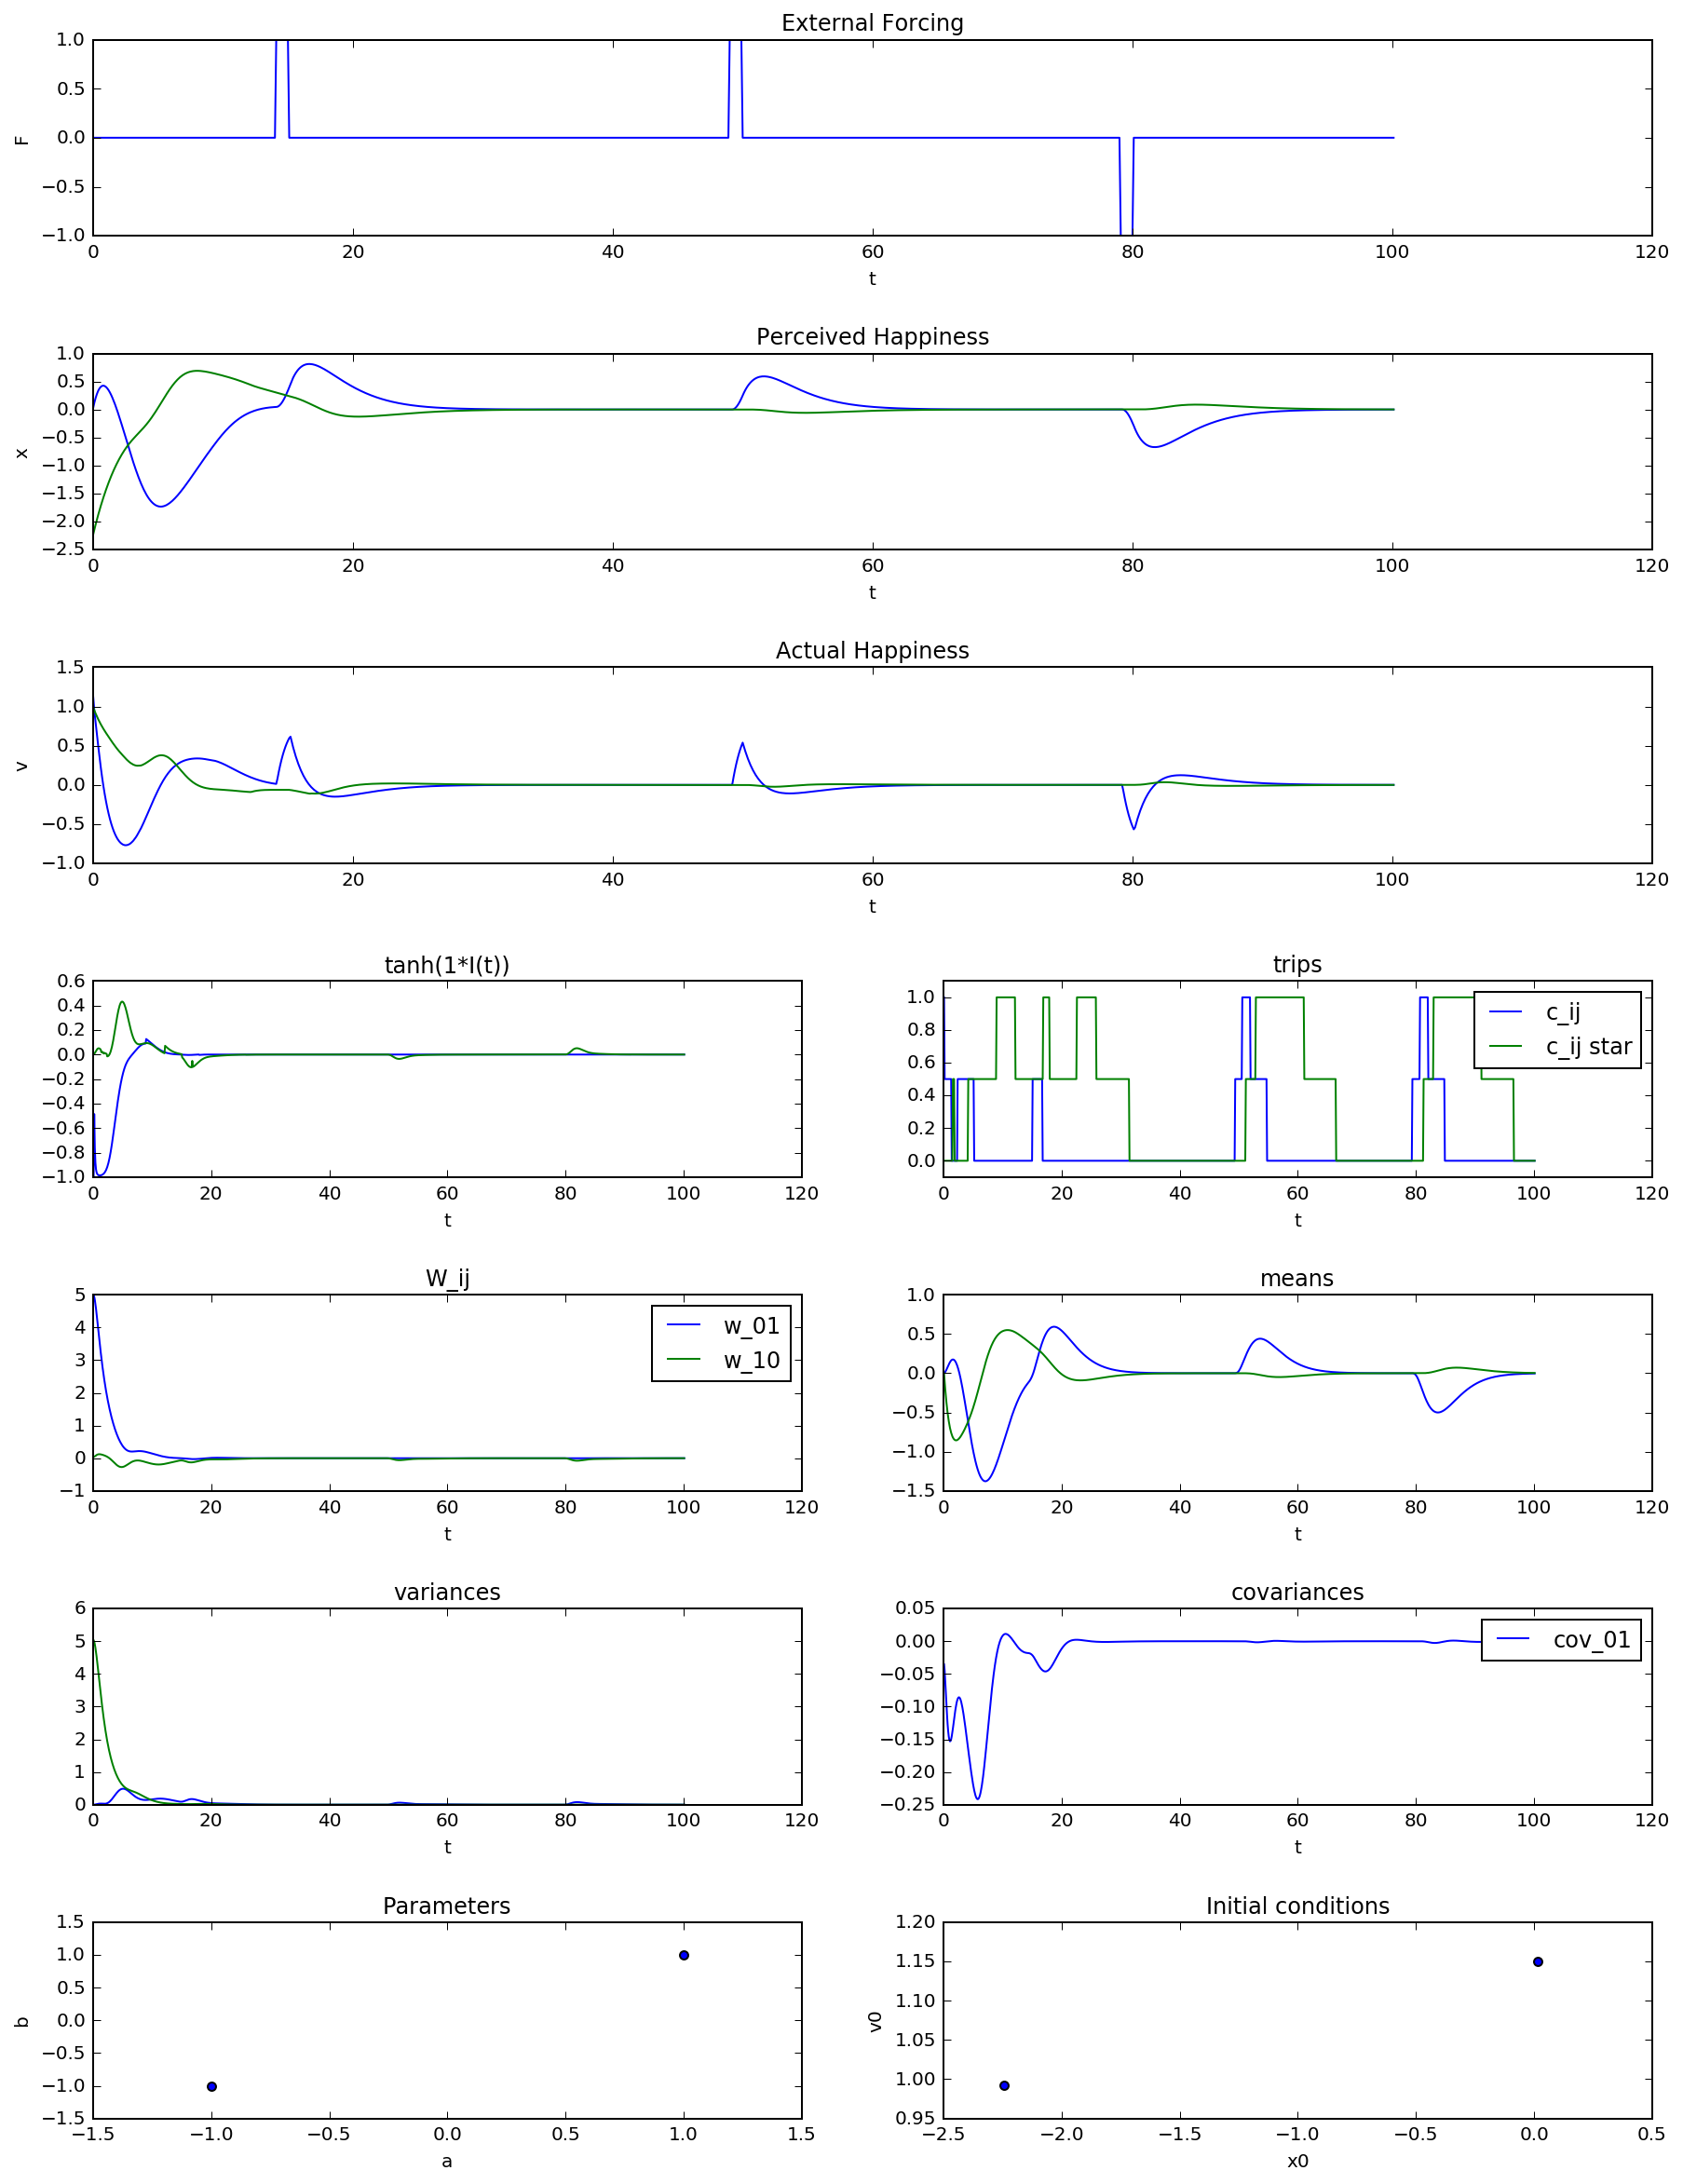

In [114]:
vibes.a = np.array([1,-1])
vibes.b = np.array([1,-1])
x, v, t = vibes.run(F=F)

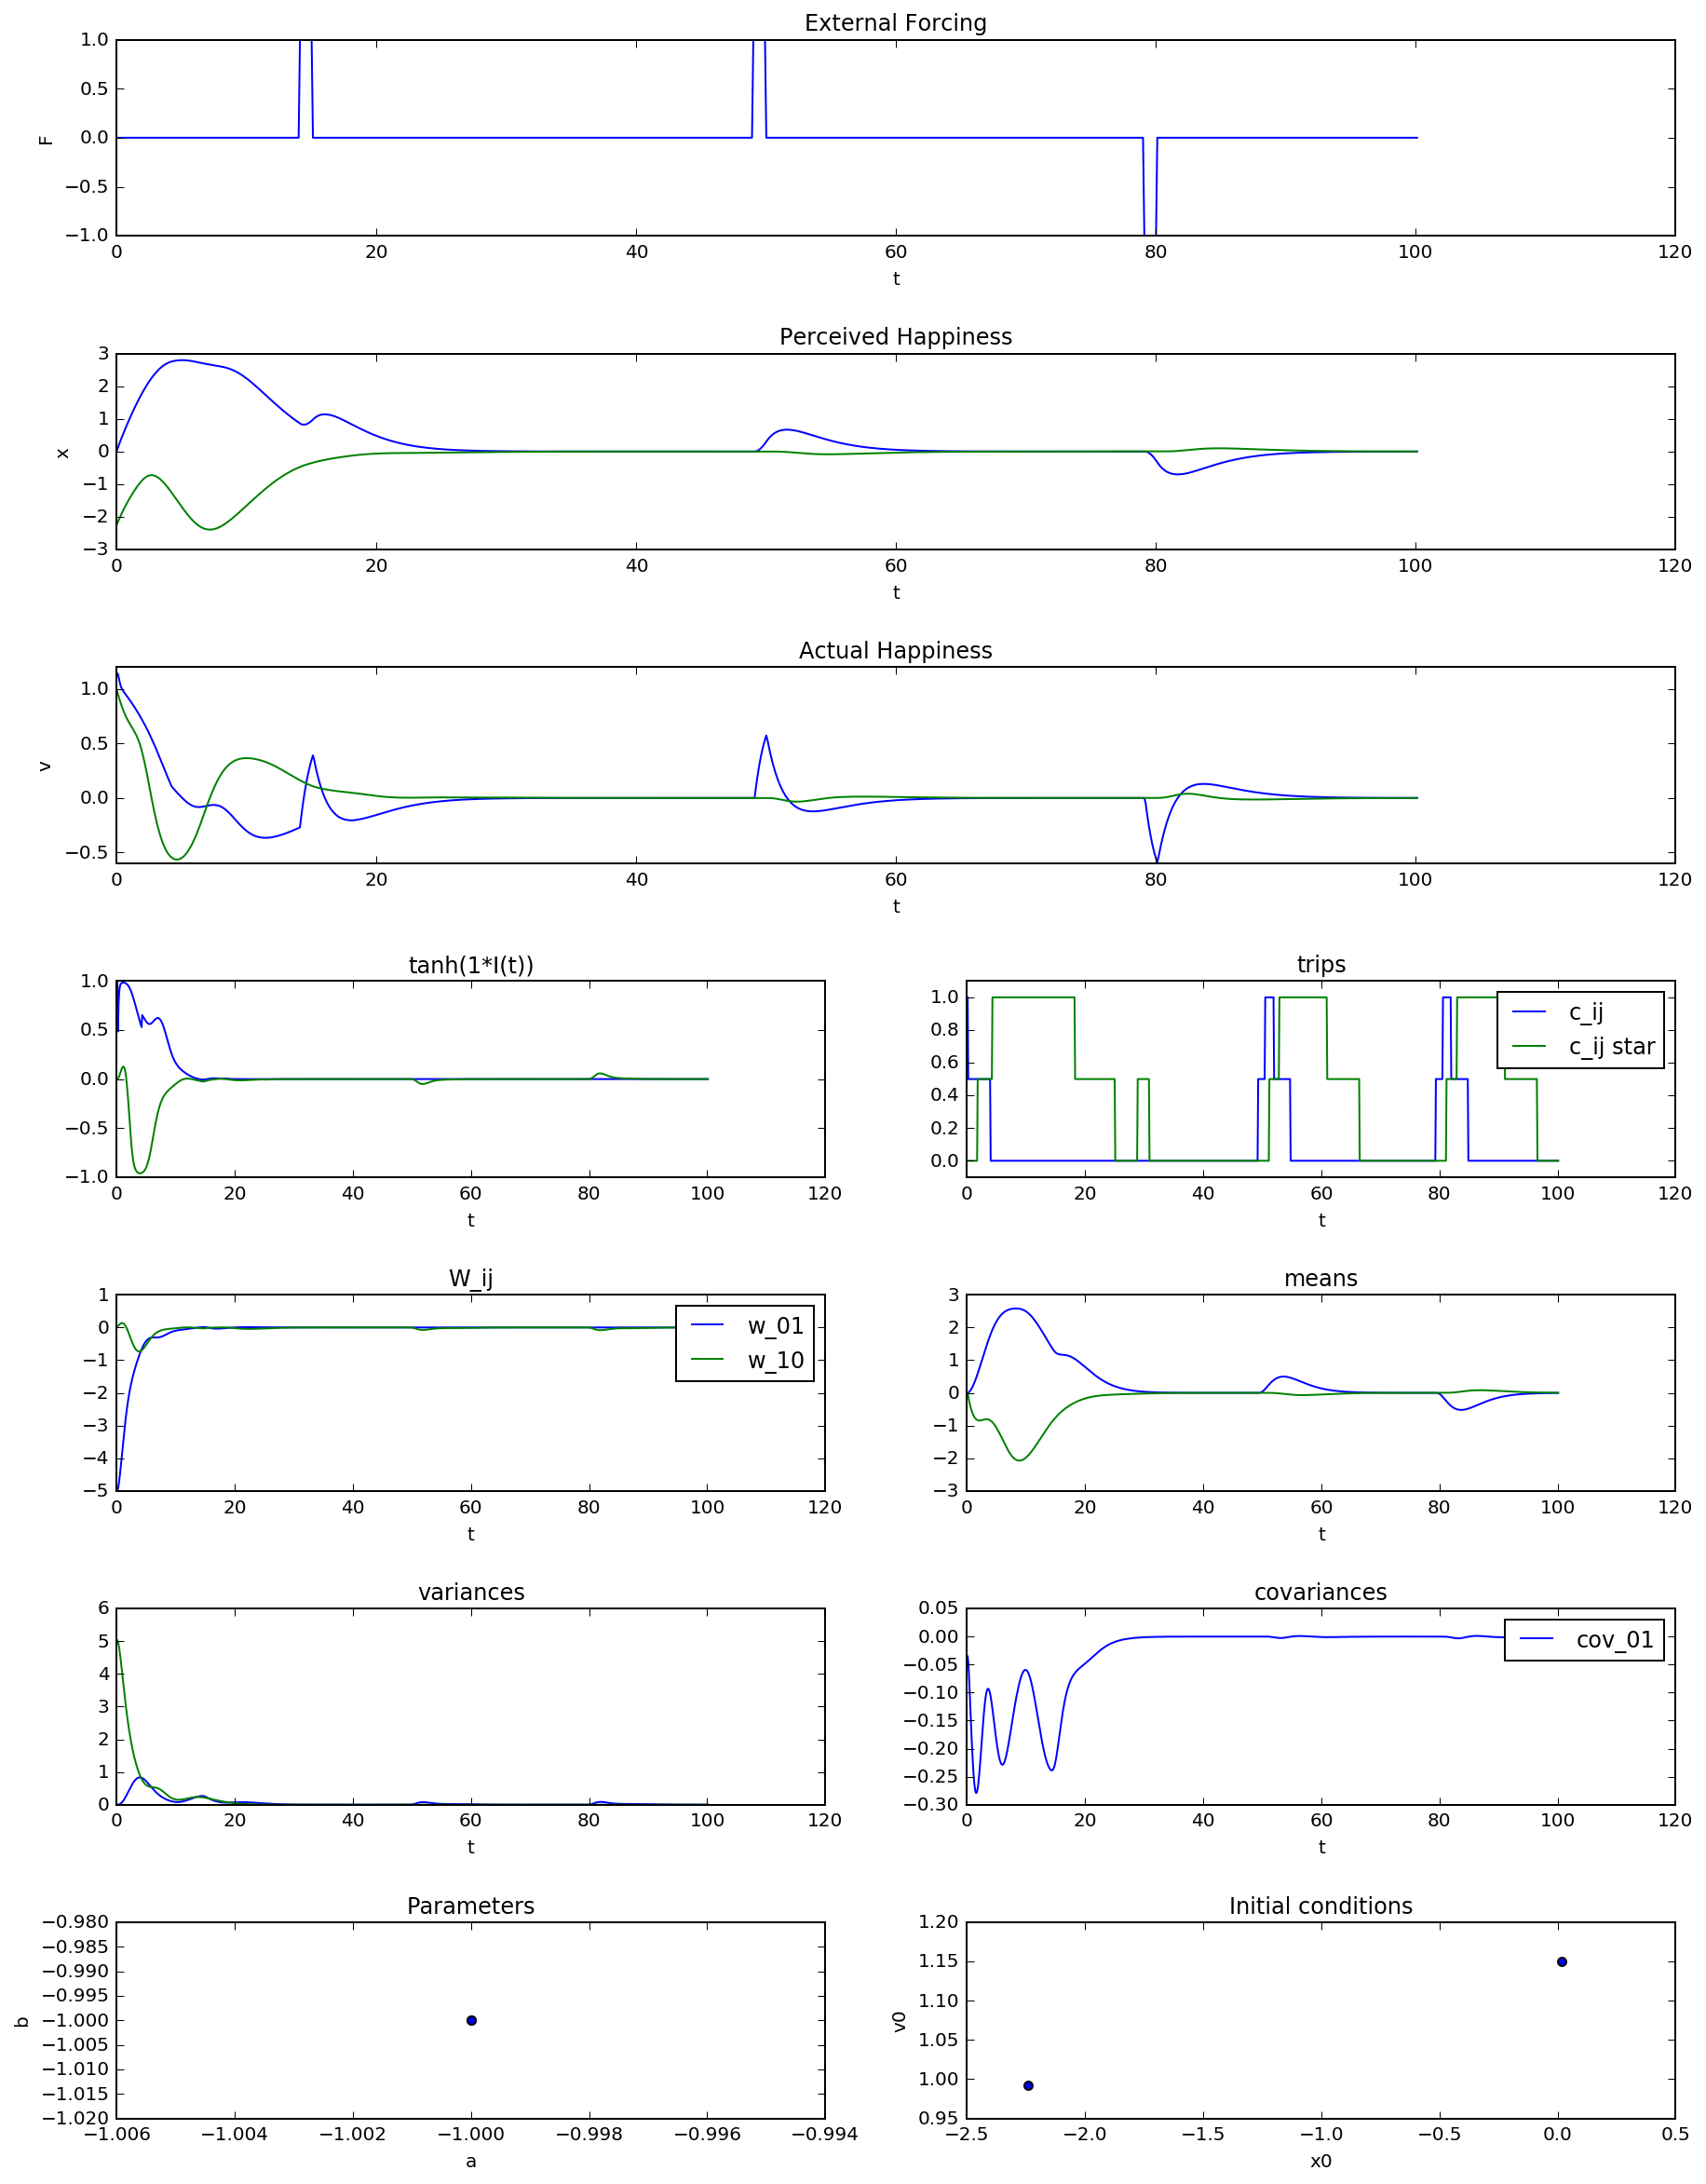

In [115]:
vibes.a = np.array([-1,-1])
vibes.b = np.array([-1,-1])
x, v, t = vibes.run(F=F)

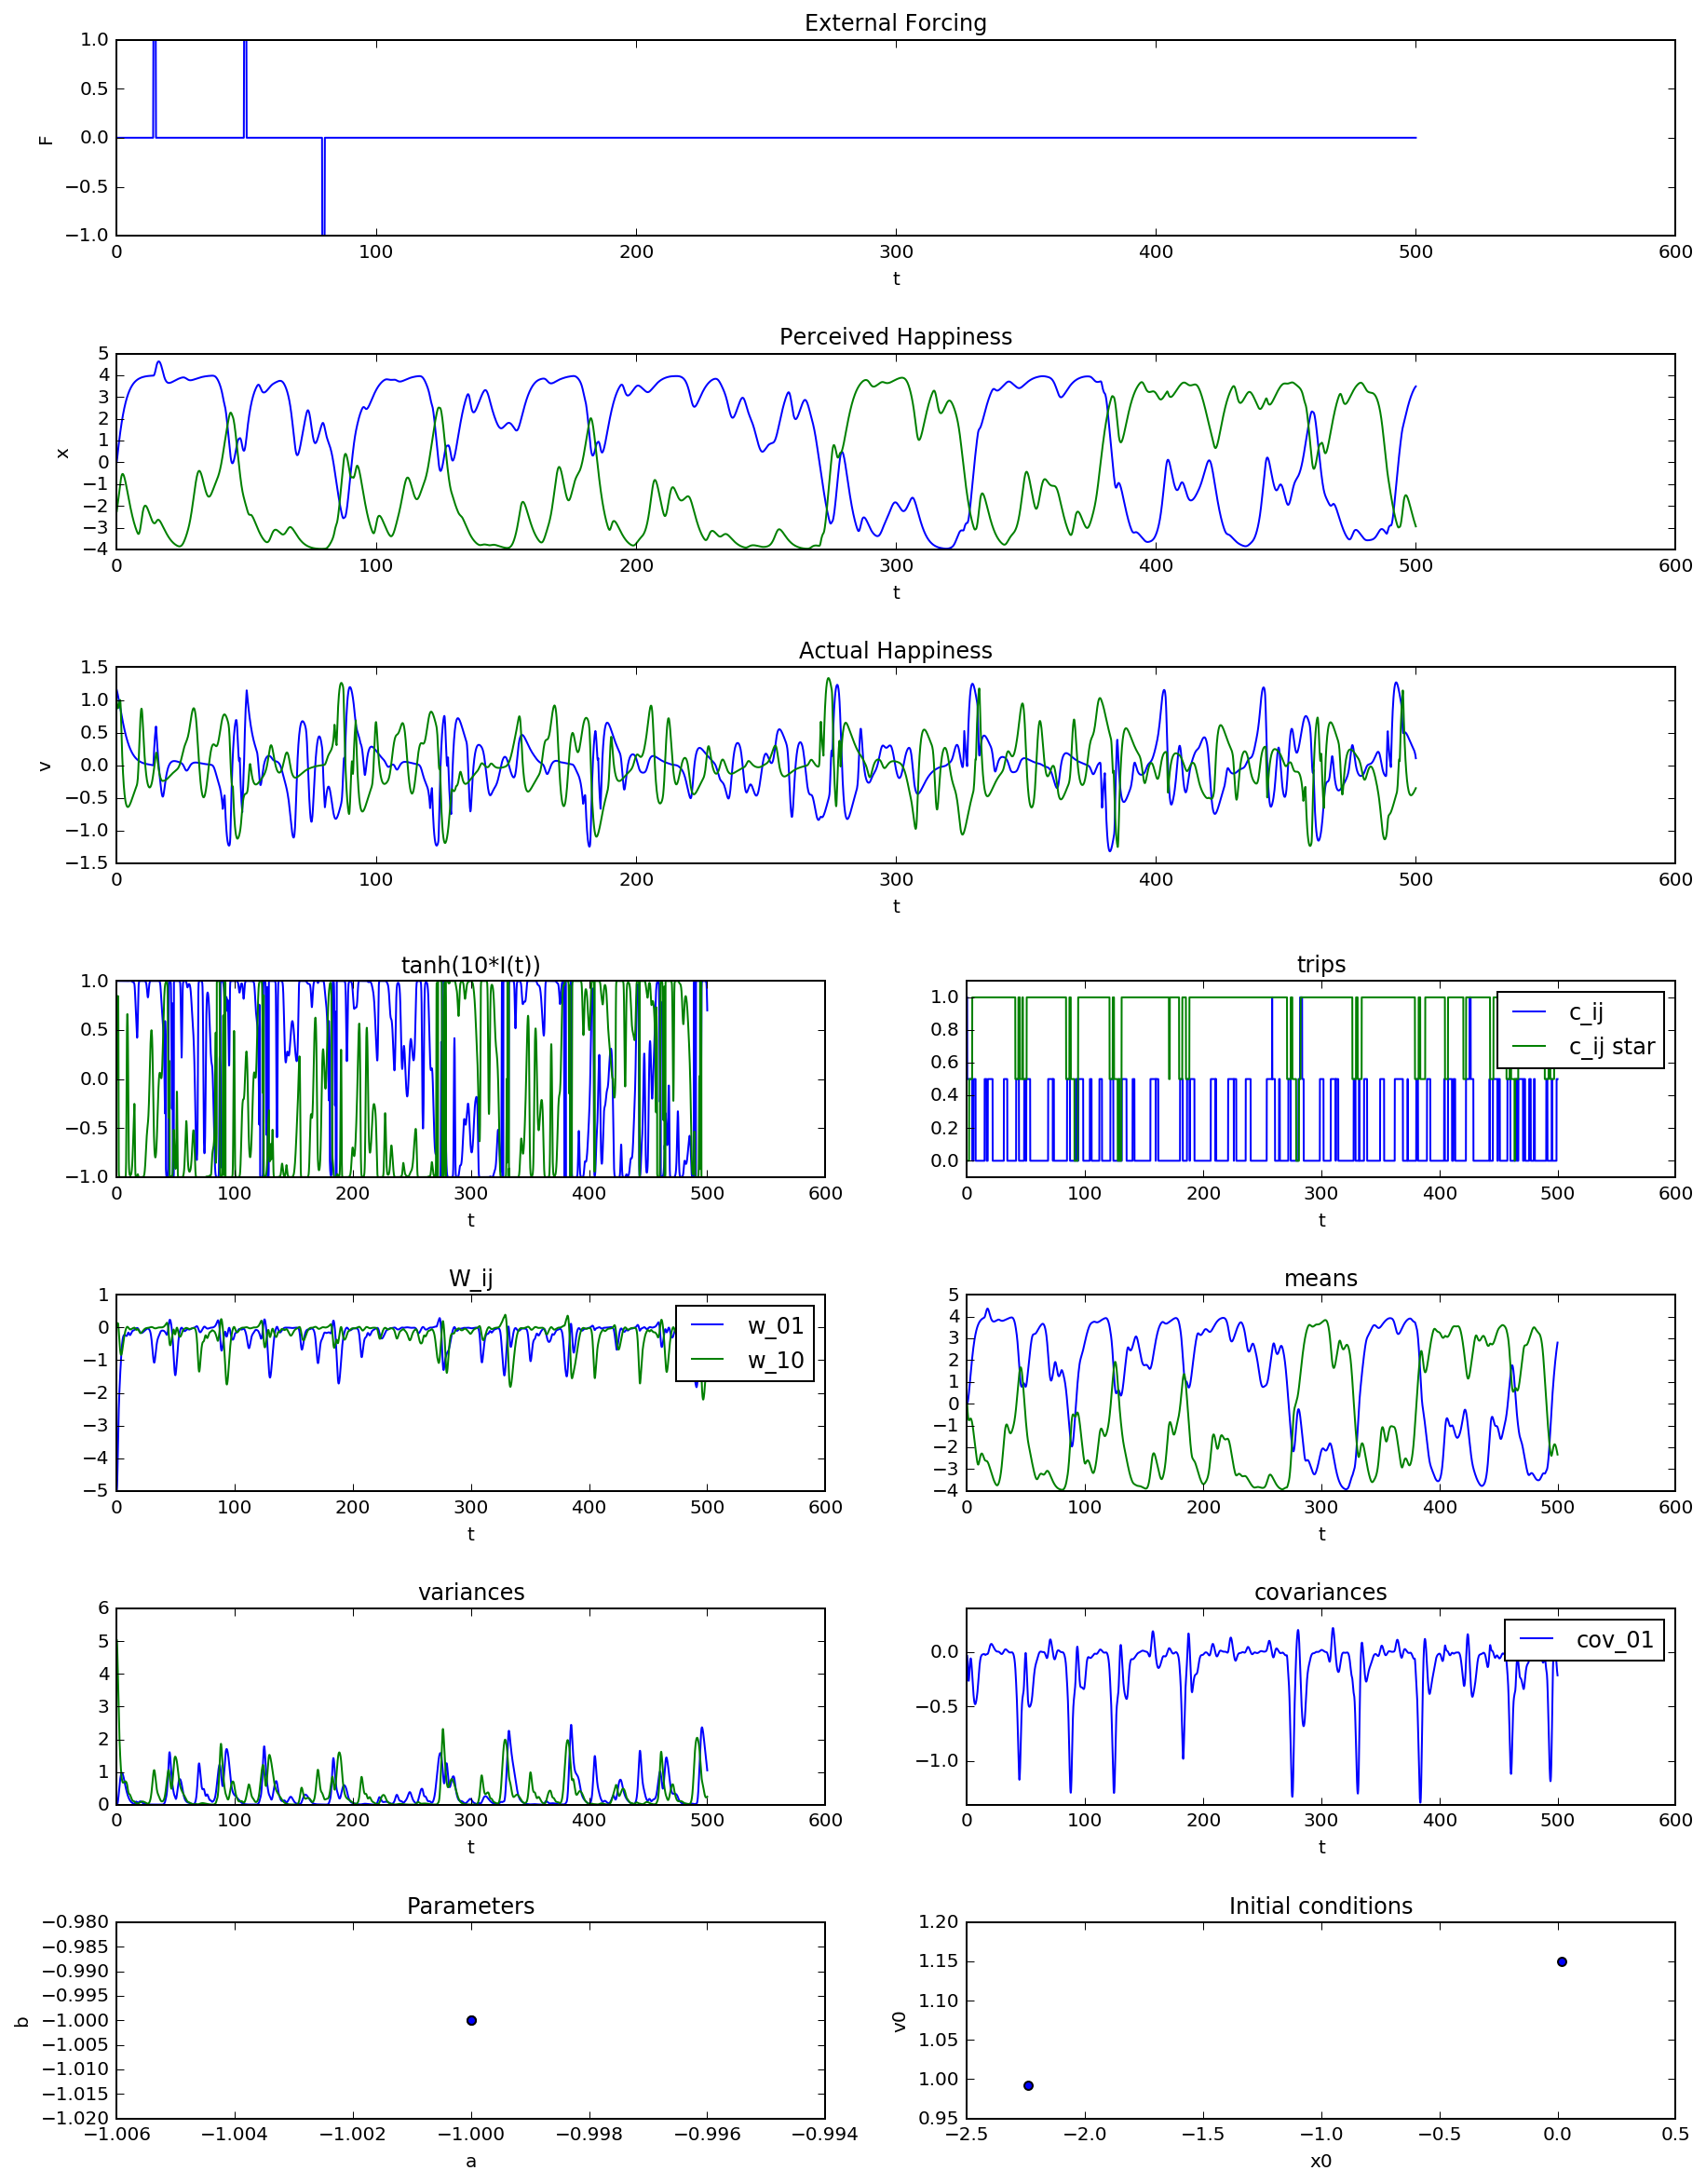

In [116]:
vibes.gain = 10
vibes.a = np.array([-1,-1])
vibes.b = np.array([-1,-1])
x, v, t = vibes.run(F=F, time = 500)

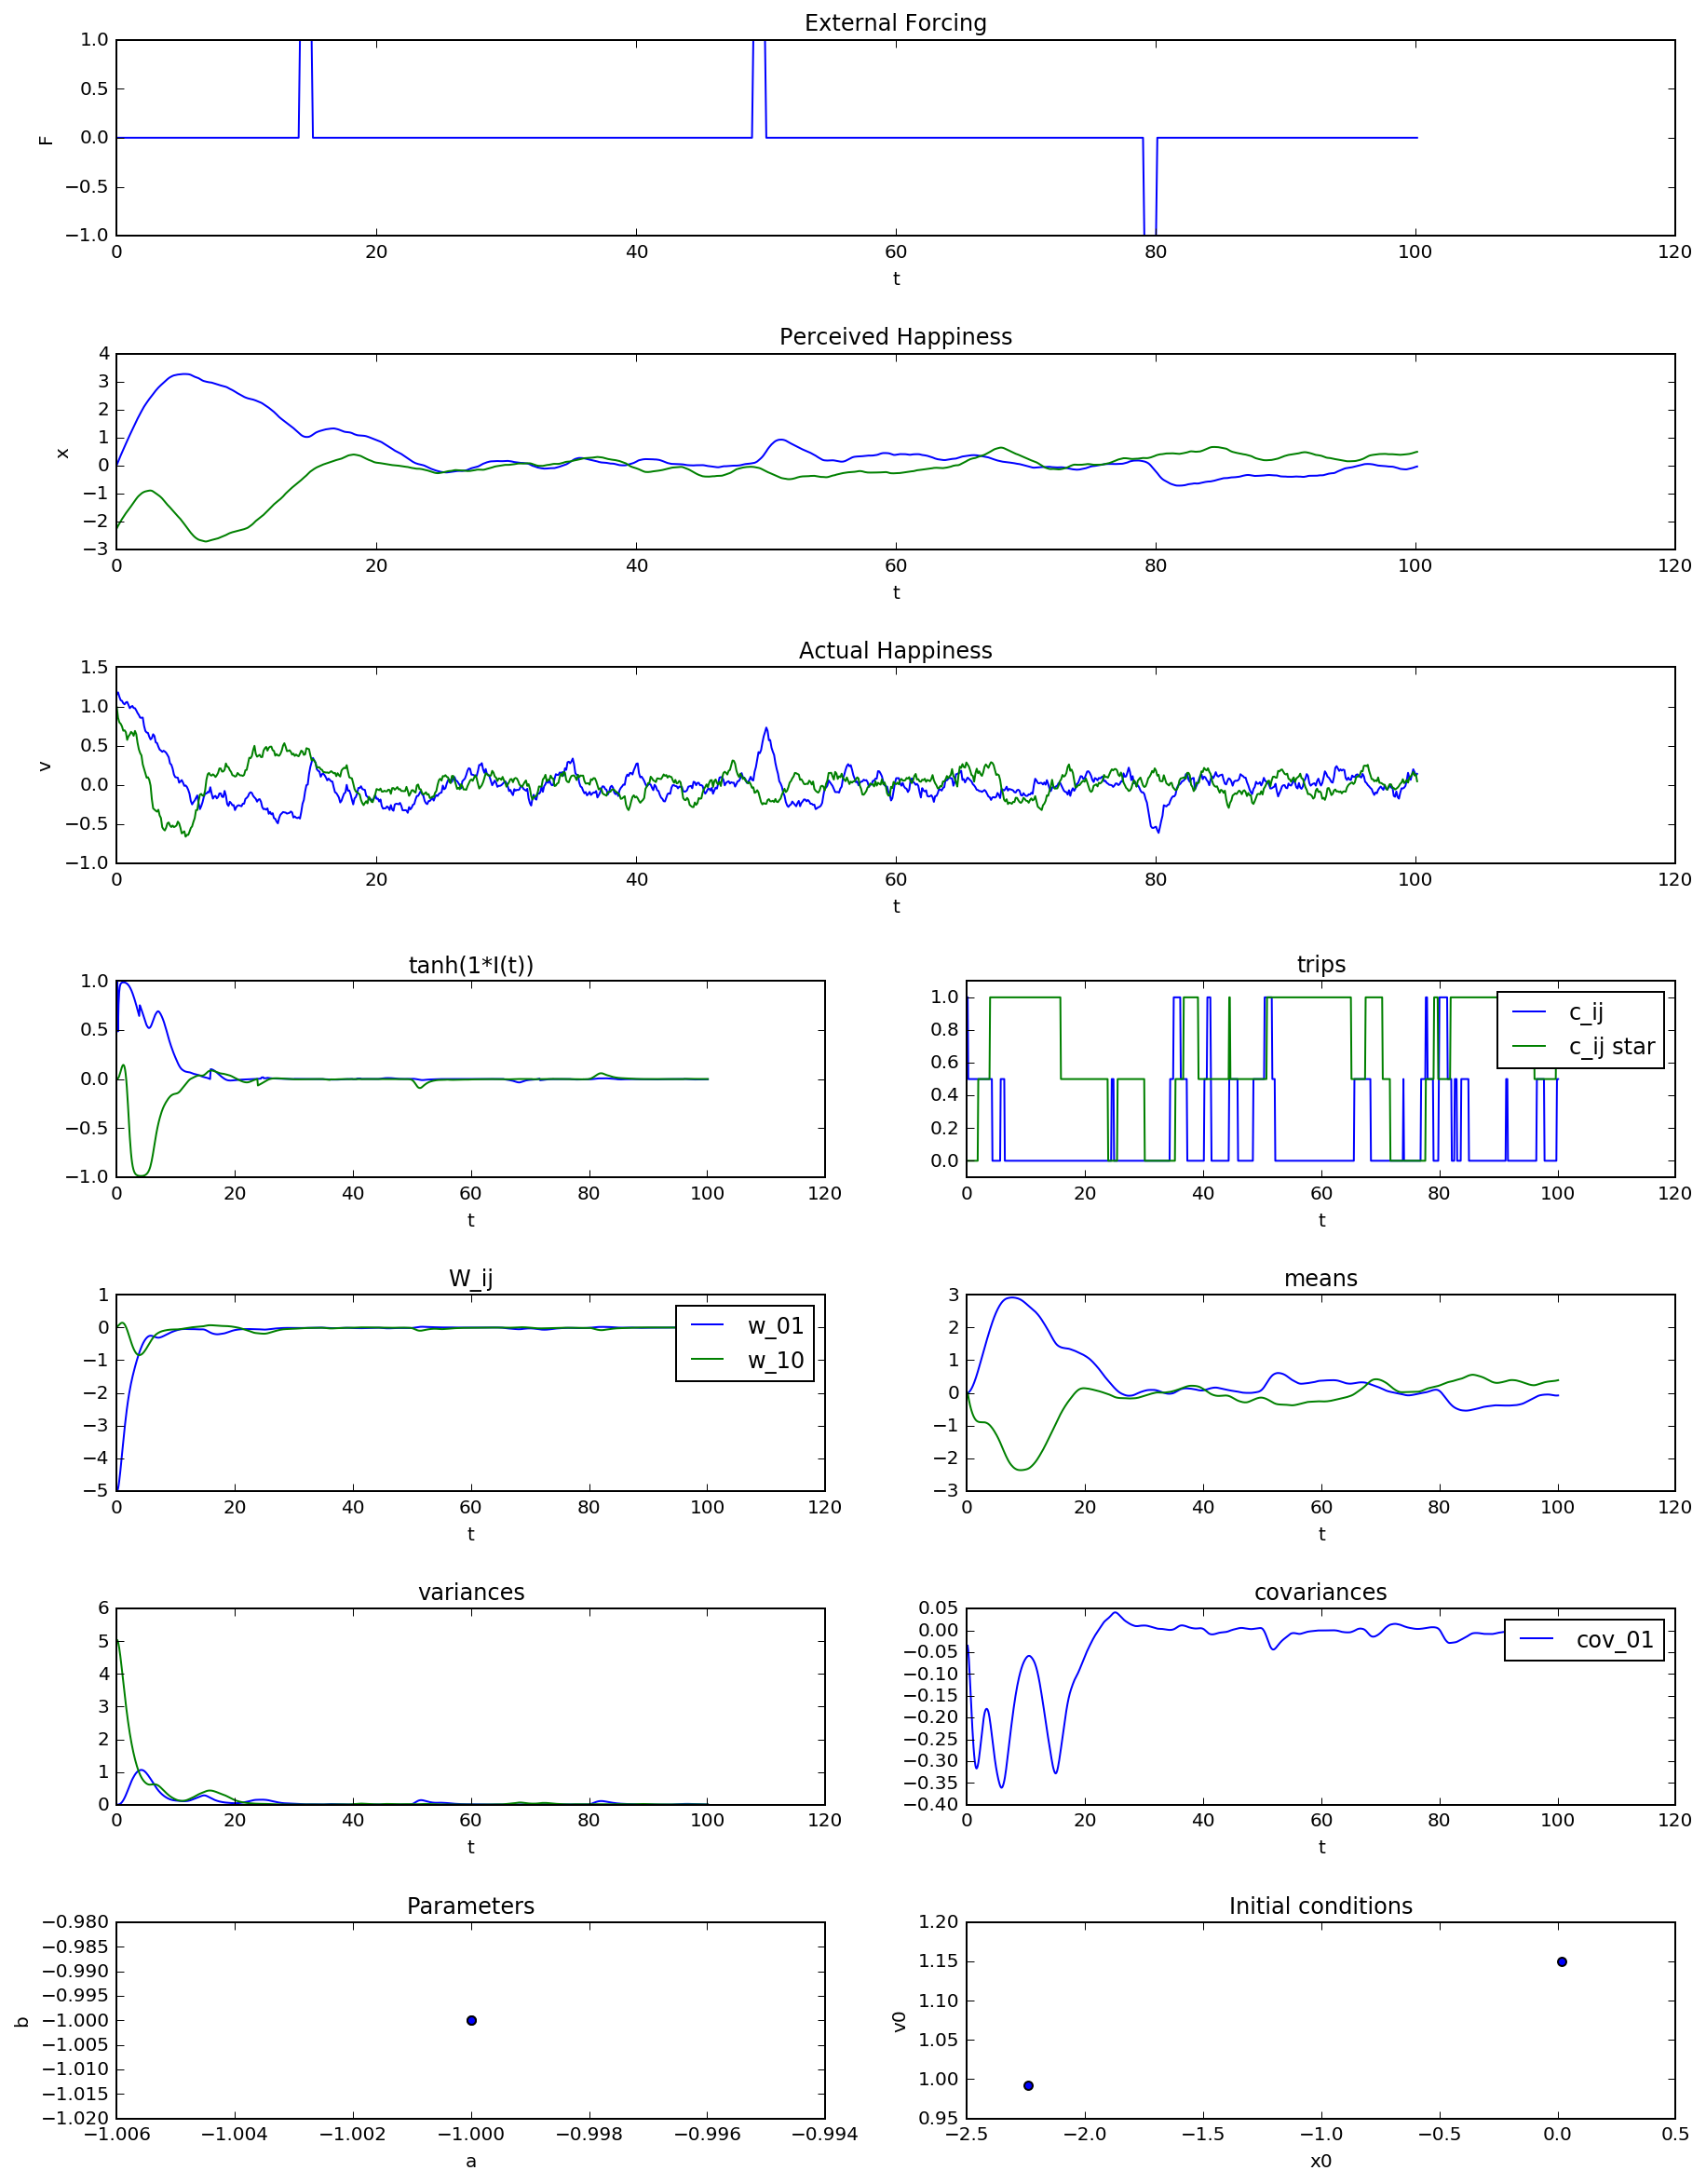

In [117]:
vibes.gain=1
x, v, t = vibes.run(noise=True, F=F)

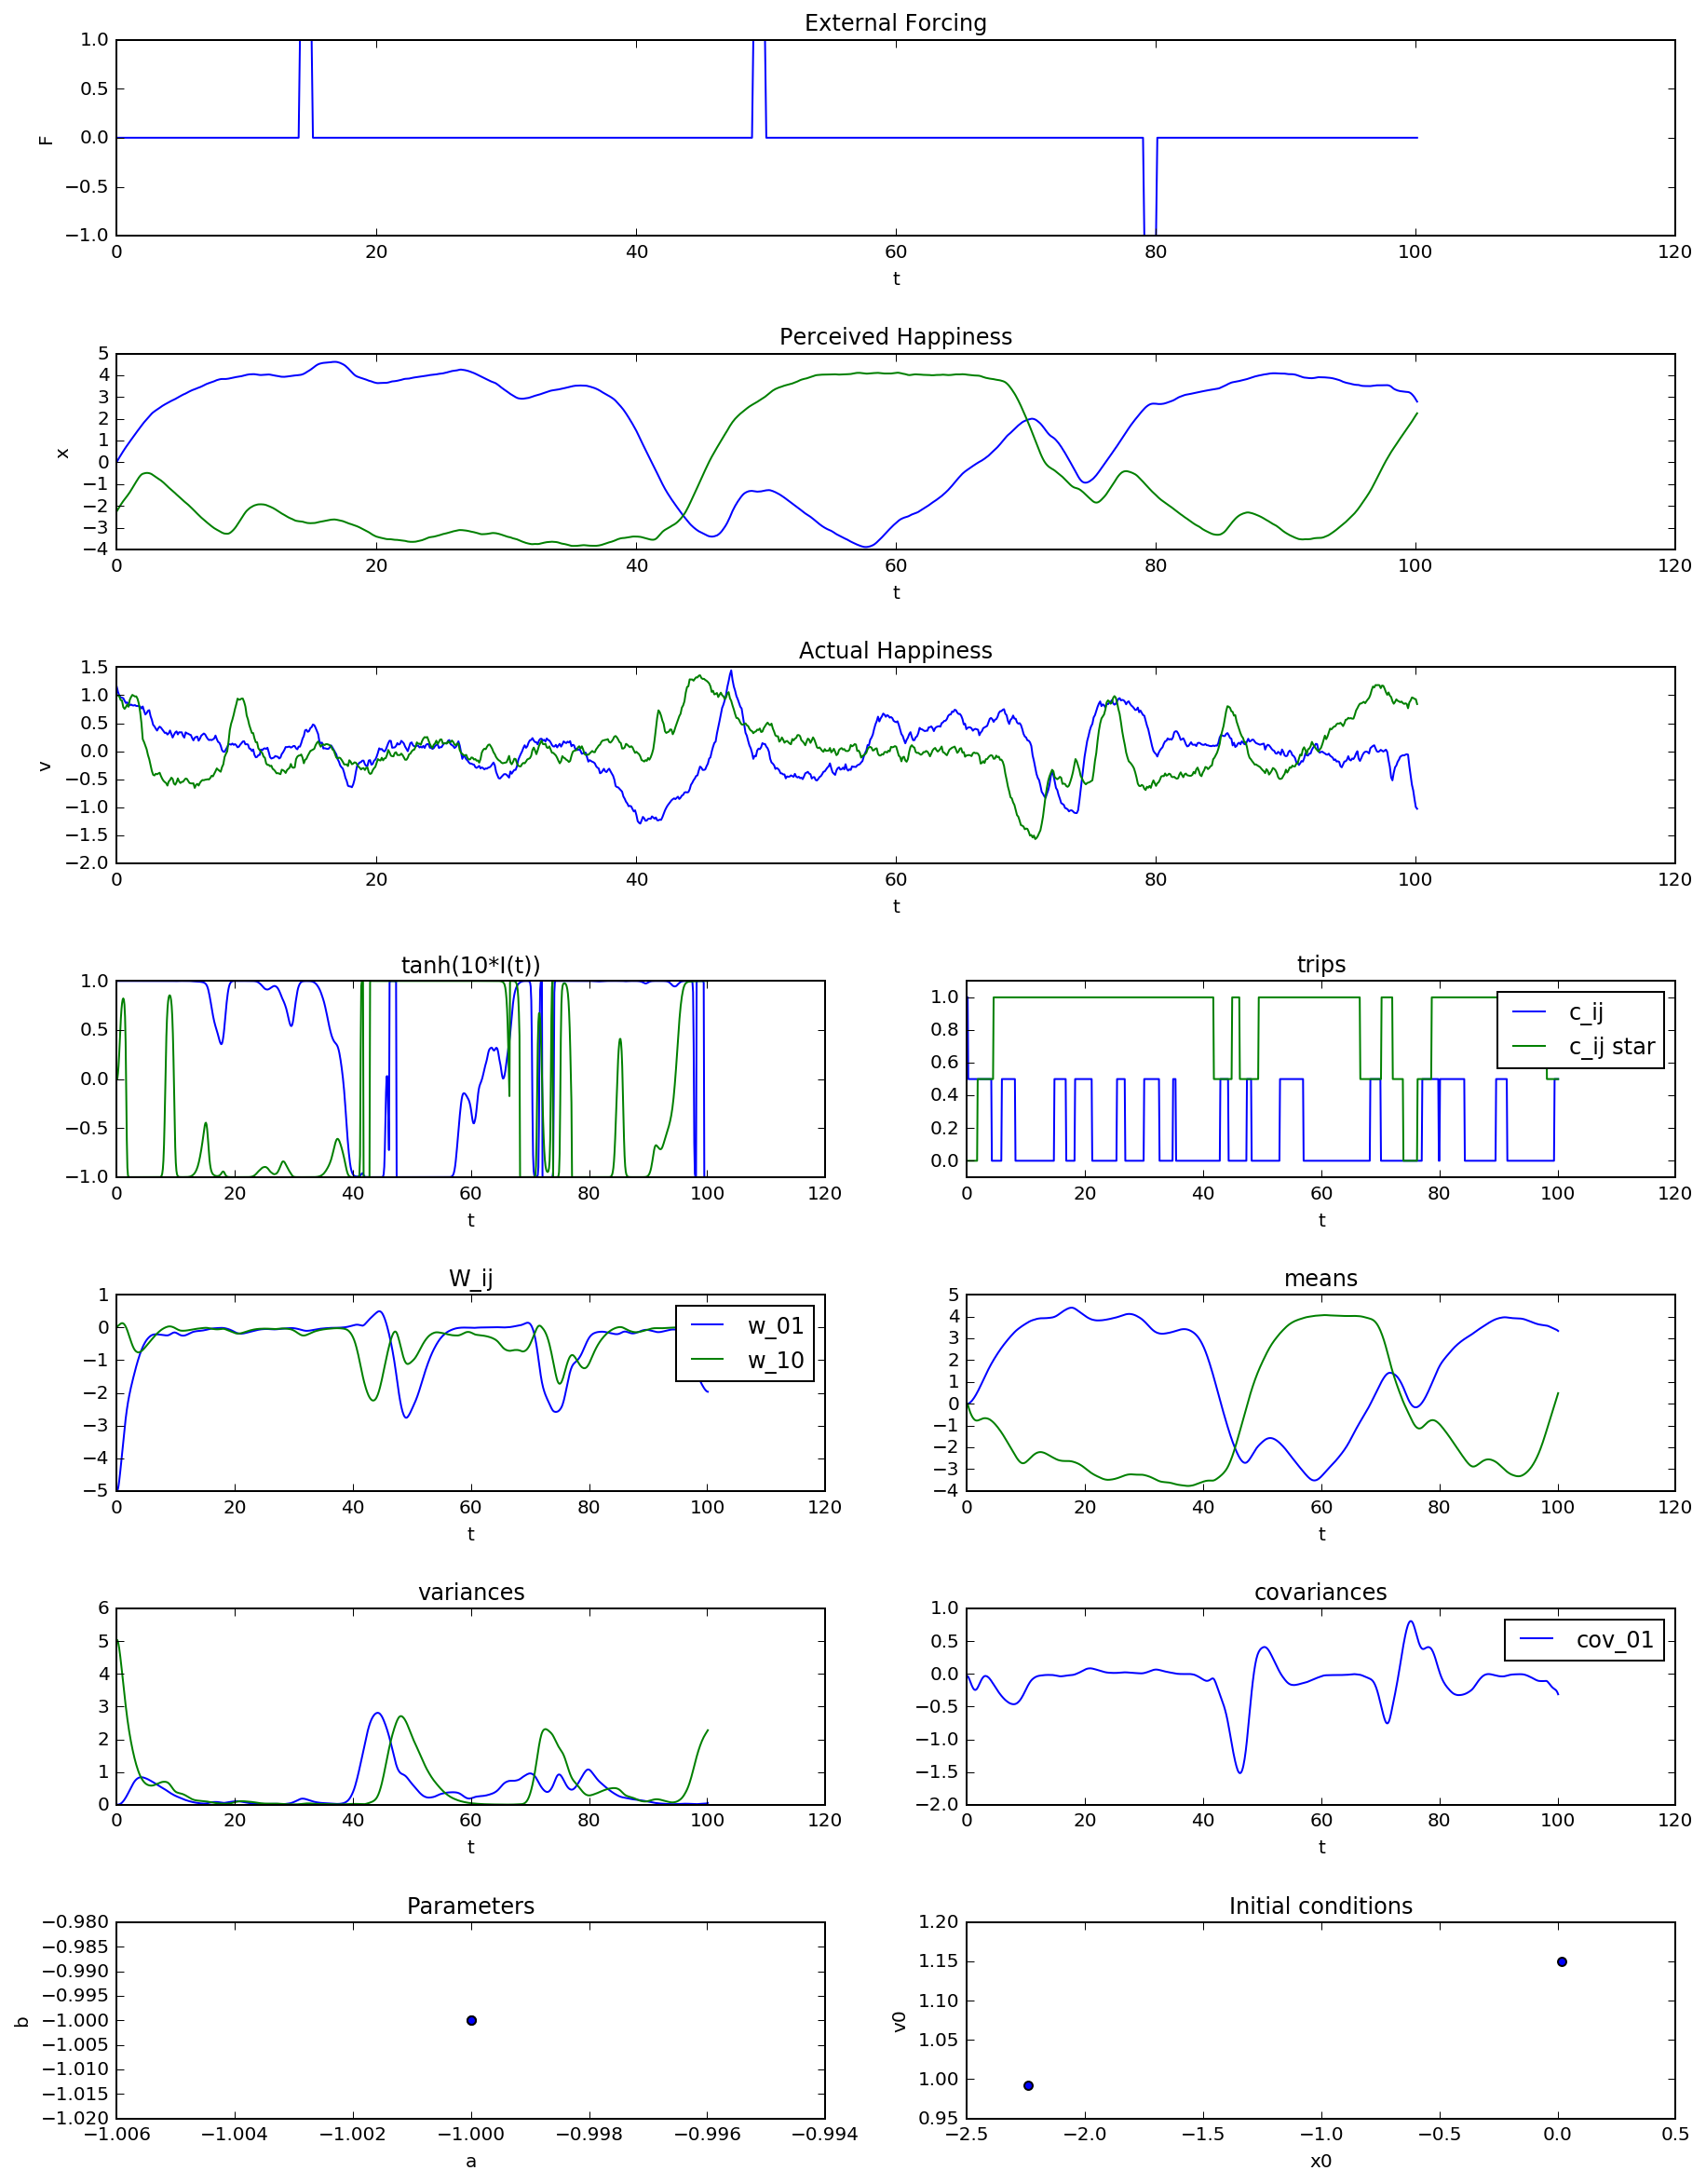

In [118]:
vibes.gain = 10
x, v, t = vibes.run(noise=True, F=F)

In [119]:
vibes.gain = 1